In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")

from functions import *
from utils import *

In [2]:
import gsmvi
from gsmvi.gsm import GSM

In [3]:
jax.config.update("jax_debug_nans", True)

## GSMVI tutorial

In [81]:
import numpy as np
import jax.numpy as jnp
from jax import jit, grad, random
import numpyro.distributions as dist

from gsmvi.gsm import GSM



In [5]:
def setup_model(D=10):
   
    # setup a Gaussian target distribution
    mean = np.random.random(D)
    L = np.random.normal(size = D**2).reshape(D, D)
    cov = np.matmul(L, L.T) + np.eye(D)*1e-3
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    return model 


In [45]:
 D = 10
model =  setup_model(D=D)
mean, cov = model.loc, model.covariance_matrix
lp = jit(lambda x: jnp.sum(model.log_prob(x)))
lp_g = jit(grad(lp, argnums=0))

###
# Fit with GSM
niter = 500
key = random.PRNGKey(99)
gsm = GSM(D=D, lp=lp, lp_g=lp_g)
mean_fit, cov_fit = gsm.fit(key, niter=niter)

print("\nTrue mean : ", mean)
print("Fit mean  : ", mean_fit)

Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500
Iteration 500 of 500

True mean :  [0.16400118 0.0911306  0.18975489 0.36765218 0.84365979 0.43875315
 0.87817315 0.82198093 0.62573563 0.7308133 ]
Fit mean  :  [0.16400082 0.09113096 0.18975478 0.36765194 0.84365916 0.4387533
 0.8781734  0.8219807  0.62573457 0.73081344]


In [52]:
mean = jnp.zeros(D)
cov = jnp.identity(D)
samples = np.random.multivariate_normal(mean=mean, cov=cov, size=1)
# samples = MultivariateNormal(loc=mean, covariance_matrix=cov).sample(key, (batch_size,))
vs = lp_g(samples)

In [49]:
vs.shape

(2, 10)

In [51]:
model.log_prob(samples)

Array([-27.883259, -22.486282], dtype=float32)

In [5]:
import jax
import jax.numpy as jnp

# Define a simple element-wise addition function
def add_fn(x, y):
    return x + y

# Create input arrays
x = jnp.array([[1, 2, 3], [4, 5, 6]])
y = jnp.array([[10, 20, 30], [40, 50, 60]])

# Vectorize add_fn over the first axis of both x and y
vmap1 = jax.vmap(add_fn, in_axes=(0, 0))

# Further vectorize over the second axis of both x and y
vmap2 = jax.vmap(vmap1, in_axes=(1, 1))

# Apply nested vmap
result = vmap2(x, y)

print(result)


INFO:jax._src.lib.xla_bridge:Remote TPU is not linked into jax; skipping remote TPU.
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter Host
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[[11 44]
 [22 55]
 [33 66]]


In [6]:
def multiply_by_two(x):
    return x * 2

# Vectorizing the function over the first dimension
vmap_multiply_by_two = jax.vmap(multiply_by_two)

# Applying to a 2D array
inputs = jnp.array([[1, 2, 3], [4, 5, 6]])
outputs = vmap_multiply_by_two(inputs)
print(outputs)  # Output: [[2, 4, 6], [8, 10, 12]]


[[ 2  4  6]
 [ 8 10 12]]


In [7]:
# Nesting jax.vmap to vectorize over both dimensions
nested_vmap_multiply_by_two = jax.vmap(jax.vmap(multiply_by_two))

# Applying to a 2D array
outputs = nested_vmap_multiply_by_two(inputs)
print(outputs)  # Output: [[2, 4, 6], [8, 10, 12]]


[[ 2  4  6]
 [ 8 10 12]]


In [4]:
def logprior(dmap_flat, num_probes):
    """
    """
    return jnp.sum(jnp.array(logprior_(dmap_flat, num_probes)))

@partial(jax.jit, static_argnums=(1, ))
def logprior_(dmap_flat, num_probes):
    """
    """
    # Get 2D map back to simplify the expression 
    dmap = jnp.reshape(dmap_flat, [num_probes, num_probes])
    
    # Calculate the squared end-to-end distance 
    R_sq = dmap[0][-1] ** 2
    
    # Calculate the average bond length
    b = jnp.mean(jnp.diag(dmap, 1))
    
    N = num_probes
    
    # Calculate the probability
    scaling_factor = 1.5 * jnp.log(3/(2*np.pi*N*b**2))
    gaussian_term = -3*R_sq/(2*N*b**2)
    
    # print('Scaling factor = {}'.format(scaling_factor))
    # print('Gaussian term = {}'.format(gaussian_term))
    
    return scaling_factor, gaussian_term 

In [5]:
def gsm_helper(x, num_components, dimensions):
    # make sure the dimensions are correct
    # assert x.shape[0] == num_components * dimensions
    num_samples = x.shape[0]
    
    # # reshape the input
    # x = jnp.reshape(x, [num_components, dimensions])
    
    vmap_batch_lp = jax.vmap(log_posterior, in_axes=(0, None, None, None, None, None, None))
    
    # calculate the log posterior 
    # change this argument in real function 
    lp = jnp.sum(vmap_batch_lp(x, observation_flatten_list, true_weights, measurement_error, num_probes, num_components, dimensions))
    
    return lp

In [6]:
def log_posterior(metastructures, observations, metastructure_weights,
                  measurement_error, num_probes, num_components, dimensions):
    """
    Calculate the logarithm of the posterior probability distribution.

    Parameters
    ----------
    metastructures : 2-dimension array_like
        The metastructures representing the chromatin ensemble.
    observations : array_like
        The flattened observations.
    metastructure_weights : array_like
        The number of observations for each probe.
    measurement_error : float
        The measurement error.
    num_probes : int
        The number of probes.

    Returns
    -------
    float
        The logarithm of the posterior probability distribution.
    """
    metastructures = jnp.array(metastructures)
    # jax.debug.print("{x}", x=metastructures.shape)
    metastructures = jnp.reshape(metastructures, [num_components, dimensions])
    
    # Make sure metastructures, observations, and metastructure_weights are jnp arrays
    
    observations = jnp.array(observations)
    # jax.debug.print("{x}", x=observations.shape)
    metastructure_weights = jnp.array(metastructure_weights)
    
    # Set weight prior to be categorical distribution
    weight_prior = 1/len(metastructure_weights)
    
    # Calculate log posterior in batch using vmap
    vmap_batch_log_posterior = jit(jax.vmap(log_posterior_one_obs, in_axes=(None, 0, None, None, None, None)), static_argnums=(3, 4, 5))
    lp = vmap_batch_log_posterior(metastructures, observations, metastructure_weights, weight_prior, measurement_error, num_probes)
    log_posterior_total = jnp.sum(lp)
    
    return log_posterior_total
    

In [7]:
# Write a helper function to calculate the argument for logsumexp function for each metastructure
def _log_posterior_one_obs_helper(metastructure, observation, metastructure_weight, weight_prior,
                  measurement_error, num_probes):
    """_summary_

    Args:
        metastructures (_type_): _description_
        observations (_type_): _description_
        metastructure_weights (_type_): _description_
        measurement_error (_type_): _description_
        num_probes (_type_): _description_
        batch_size (_type_): _description_
    """
    # Calculate log weights 
    lw = jnp.log(jnp.abs(metastructure_weight)) + 1e-32
    
    # Calculate log likelihood
    lp = loglikelihood(observation, metastructure, measurement_error, num_probes)
    
    # Calculate log prior weights
    lpw = jnp.log(weight_prior)
    
    # Calculate log prior for metastructure
    lpm = logprior(metastructure, num_probes)
    
    # jax.debug.print("{x}, {y}, {z}, {a}", x=lp, y=lpw, z=lpm, a=lw)
    
    return lw + lp + lpw + lpm
    

In [8]:
# Calculate the log posterior inside the logsumexp function
# Use vmap for autobatching 

def log_posterior_one_obs(metastructures, observation, metastructure_weights, weight_prior,
                  measurement_error, num_probes):
    """
    Calculate the logarithm of the posterior probability distribution.

    Parameters
    ----------
    metastructures : 2-dimension array_like
        The metastructures representing the chromatin ensemble.
    observations : array_like
        The flattened observations.
    metastructure_weights : array_like
        The number of observations for each probe.
    measurement_error : float
        The measurement error.
    num_probes : int
        The number of probes.

    Returns
    -------
    float
        The logarithm of the posterior probability distribution.
    """
    # Calculate the argument for logsumexp function 
    vmap_batch_lse_arg = jit(vmap(_log_posterior_one_obs_helper, (0, None, 0, None, None, None)), static_argnums=(3,4,5))
    lse_arg = vmap_batch_lse_arg(metastructures, observation, metastructure_weights, weight_prior, measurement_error, num_probes)
    
    # Calculate LSE
    lse = jax.scipy.special.logsumexp(lse_arg)
    
    return lse

In [9]:
def load_dataset(pickle_file):
    """
    Load the dataset from the pickle file.

    Parameters
    ----------
    pickle_file : str
        The path to the pickle file containing the dataset.

    Returns
    -------
    tuple
        A tuple of the observation list, the true labels, and a dictionary of parameters.

    Raises
    ------
    FileNotFoundError
        If the pickle file does not exist.

    Notes
    -----
    This function loads the dataset from a pickle file. The pickle file should contain a tuple
    with the observation list and the true labels. It also extracts parameters from the file name
    and puts them in a dictionary.

    Example
    -------
    >>> pickle_file = 'data.pickle'
    >>> observation_list, labels_true, param_dict = load_dataset(pickle_file)
    """
    with open(pickle_file, 'rb') as f:
        dataset_list = pickle.load(f)

        
    # Extract parameters from file name
    # Remove .pkl file suffix
    pickle_file = pickle_file.replace('.pkl', '')
    params = os.path.basename(pickle_file).split('_')[1:]
    params = [int(p) if p.isdigit() else float(p) for p in params]

    # Put the parameters in a dictionary
    param_dict = {
        'num_monomers': params[0],
        'mean_bond_length': params[1],
        'std_bond_length': params[2],
        'num_templates': params[3],
        'weights_dist': params[4],
        'noise_std': params[5],
        'num_observations': params[6]
    }
        
    return dataset_list, param_dict

In [10]:
# Load the data from the dataset 
dataset_dir = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_100_1000_20.0_10000.pkl'

In [11]:
dataset_list, param_dict = load_dataset(dataset_dir)

In [12]:
param_dict

{'num_monomers': 100,
 'mean_bond_length': 10,
 'std_bond_length': 20,
 'num_templates': 100,
 'weights_dist': 1000,
 'noise_std': 20.0,
 'num_observations': 10000}

In [13]:
num_observations = 10000
num_monomers = 100

# Sample the dataset according to num_observation
# Generate random indices that will randomly pickl num_observations from the list
indices = np.random.choice(len(dataset_list[0]['observation_list']), num_observations, replace=False)

template_list = dataset_list[0]['template_chain_list']
X = dataset_list[0]['observation_list'][indices]
label_list = dataset_list[0]['labels'][indices]

observation_flatten_list = [squareform(pdist(x[:num_monomers, :])).flatten() for x in X]

In [14]:
observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
true_weights = true_weights.reshape(-1, 1)

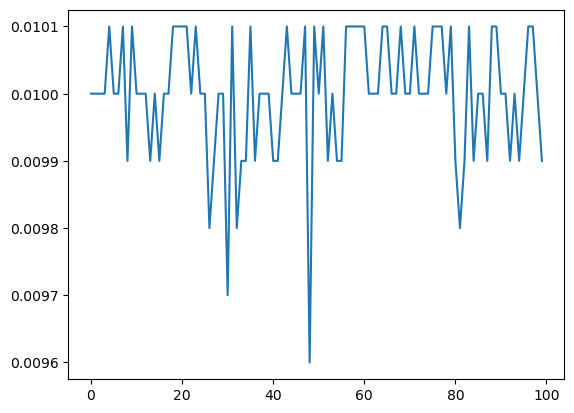

In [15]:
plt.plot(true_weights)

In [16]:
templates_flatten = [squareform(pdist(x[:num_monomers, :])).flatten() for x in template_list]

In [17]:
# Generate random walk for guessing structures
# num_monomers = param_dict['num_monomers']
num_monomers = 100
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
num_probes = num_monomers
num_candidates = 100

candidate_polymer_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for _ in range(num_candidates)]
candidate_flatten_list = [squareform(pdist(x)).flatten() for x in candidate_polymer_list]

In [18]:
# Test my new posterior functions 
log_posterior(candidate_flatten_list, candidate_flatten_list, true_weights,
                  measurement_error, num_probes, num_templates, 100**2)

INFO:jax._src.lib.xla_bridge:Remote TPU is not linked into jax; skipping remote TPU.
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Host Interpreter
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


Array(-3921051.98230144, dtype=float64)

In [19]:
np.array(candidate_flatten_list).shape

(100, 10000)

In [22]:
np.array(candidate_flatten_list).shape

(100, 10000)

In [122]:
type(num_probes)

int

In [123]:
lp = jit(lambda x: log_posterior(x, observation_flatten_list, true_weights, measurement_error, num_probes, num_candidates, num_monomers**2))
lp_g = jit(grad(lp, argnums=0))

In [35]:
observation_flatten_list[0].shape

(400,)

In [34]:
lp = jit(lambda x: -gsm_helper(x, num_candidates, num_monomers**2))
lp_g = jit(grad(lp, argnums=0))

In [35]:
gsm = GSM(D=num_candidates*num_monomers**2, lp=lp, lp_g=lp_g)

In [36]:
key = random.PRNGKey(90)
niter = 5000
nprint = 50
batch_size = 2

In [37]:
mean_fit, cov_fit = gsm.fit(key, niter=niter, nprint=nprint)

2024-07-01 17:14:29.909871: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.64TiB (rounded to 4000000000000)requested by op 
2024-07-01 17:14:29.910326: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:497] *___________________________________________________________________________________________________
2024-07-01 17:14:29.910423: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2410] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 4000000000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         0B
              constant allocation:         0B
        maybe_live_out allocation:    3.64TiB
     preallocated temp allocation:         0B
                 total allocation:    3.64TiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	B

In [48]:
mean_fit.shape

(800,)

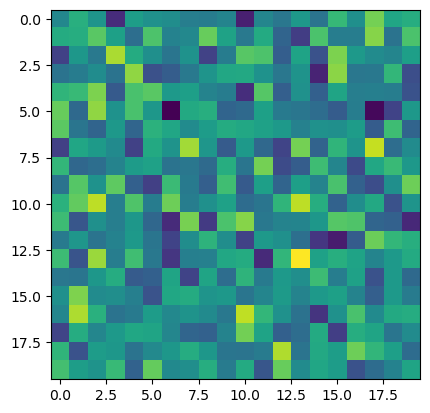

In [49]:
plt.imshow(mean_fit[:400].reshape(20, 20))

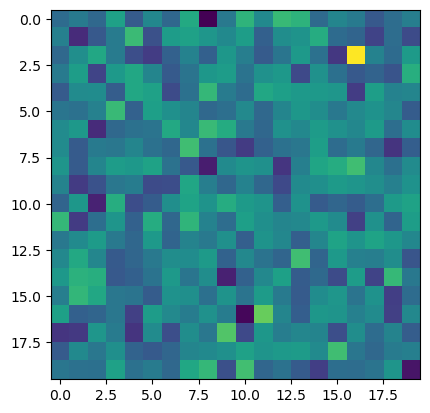

In [50]:
plt.imshow(mean_fit[400:800].reshape(20, 20))

In [23]:
len(observation_flatten_list)

10000

In [24]:
print(num_candidates * num_monomers**2)

1000000


In [25]:
np.array(candidate_flatten_list).shape

(100, 10000)

In [20]:
lp = jit(lambda x: -log_posterior(x, observation_flatten_list, true_weights, measurement_error, num_probes, num_candidates, num_monomers**2))

In [21]:
# Try my jax function
pg = ProjectedGradient(fun=lp, projection=projection_non_negative, implicit_diff=True, verbose=True)
pg_sol = pg.run(candidate_flatten_list)

INFO: jaxopt.ProximalGradient: Iter: 1 Distance btw Iterates (stop. crit.): 9780.111410293166 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 2 Distance btw Iterates (stop. crit.): 5590.476530940731 Stepsize:4.0 
INFO: jaxopt.ProximalGradient: Iter: 3 Distance btw Iterates (stop. crit.): 4922.85161401455 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 4 Distance btw Iterates (stop. crit.): 2679.0900173578602 Stepsize:4.0 
INFO: jaxopt.ProximalGradient: Iter: 5 Distance btw Iterates (stop. crit.): 3077.6469591113673 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 6 Distance btw Iterates (stop. crit.): 1469.387455173293 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 7 Distance btw Iterates (stop. crit.): 761.5738236477117 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 8 Distance btw Iterates (stop. crit.): 341.6718394604538 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 9 Distance btw Iterates (stop. crit.): 289.86903224508393 Stepsize:4.0 
INFO: jaxopt.ProximalGradi

In [31]:

# Perform UMAP projection on the observation flatten list 
# Then embed the candidate flatten list into the UMAP space
# Then embed the pg_sol into the UMAP space

# import UMAP
# import PCA 
from umap import UMAP

# Perform UMAP projection on the observation flatten list
# Embed the true templates into the UMAP space

umap = UMAP(n_components=2)
umap_templates = umap.fit_transform(templates_flatten)
umap_observation = umap.transform(observation_flatten_list)

# Embed the candidate flatten list into the UMAP space
umap_candidate = umap.transform(candidate_flatten_list)

# Embed the pg_sol into the UMAP space
umap_pg_sol = umap.transform(pg_sol.params)




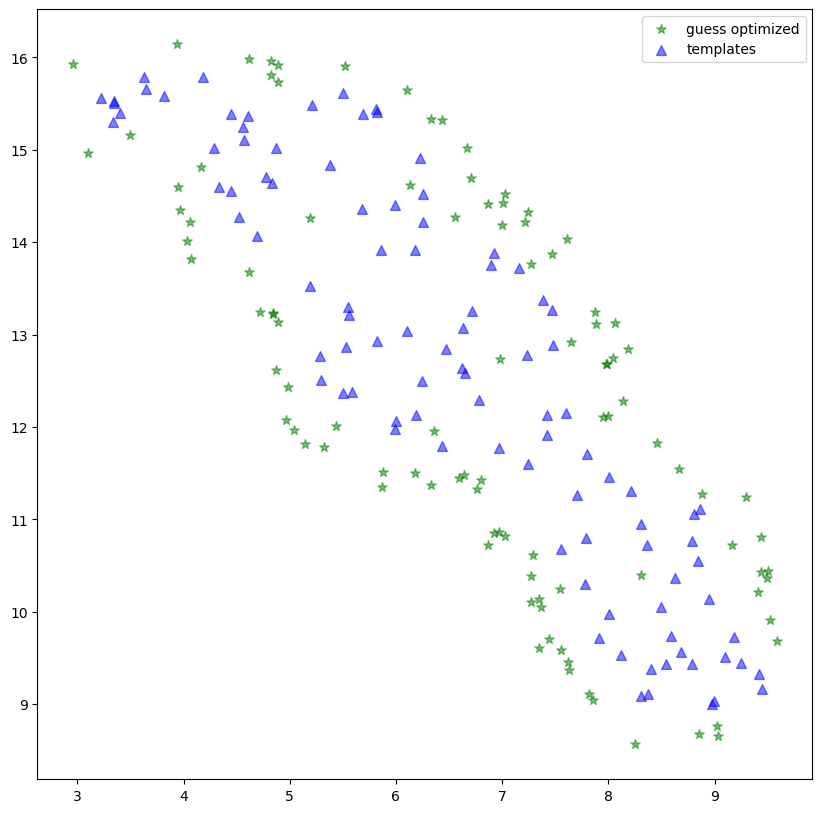

In [33]:
# Plot the UMAP projection
plt.figure(figsize=(10, 10))
# plt.scatter(umap_observation[:, 0], umap_observation[:, 1], c=label_list, cmap='tab20', s=20, alpha=0.5, label='observations')
# plt.scatter(umap_candidate[:, 0], umap_candidate[:, 1], c='r', marker='s', s=50, alpha=0.5, label='guess initial')
plt.scatter(umap_pg_sol[:, 0], umap_pg_sol[:, 1], c='g', marker='*', s=50, alpha=0.5, label='guess optimized')
plt.scatter(umap_templates[:, 0], umap_templates[:, 1], c='b', marker='^', s=50, alpha=0.5, label='templates')
plt.legend()

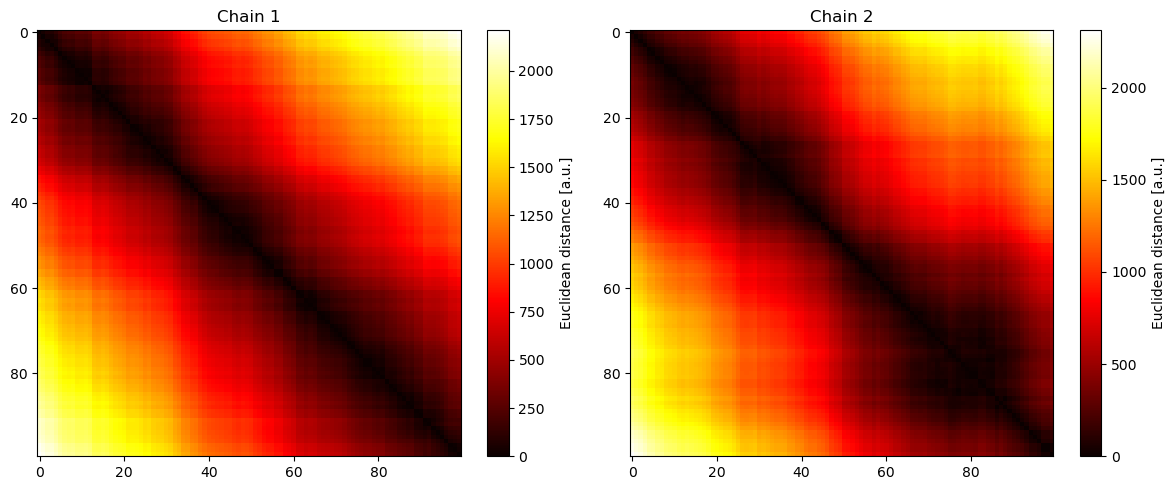

In [144]:
compare_distance_maps(templates_flatten[0], templates_flatten[1], type1='flatten_distance_map', type2='flatten_distance_map')

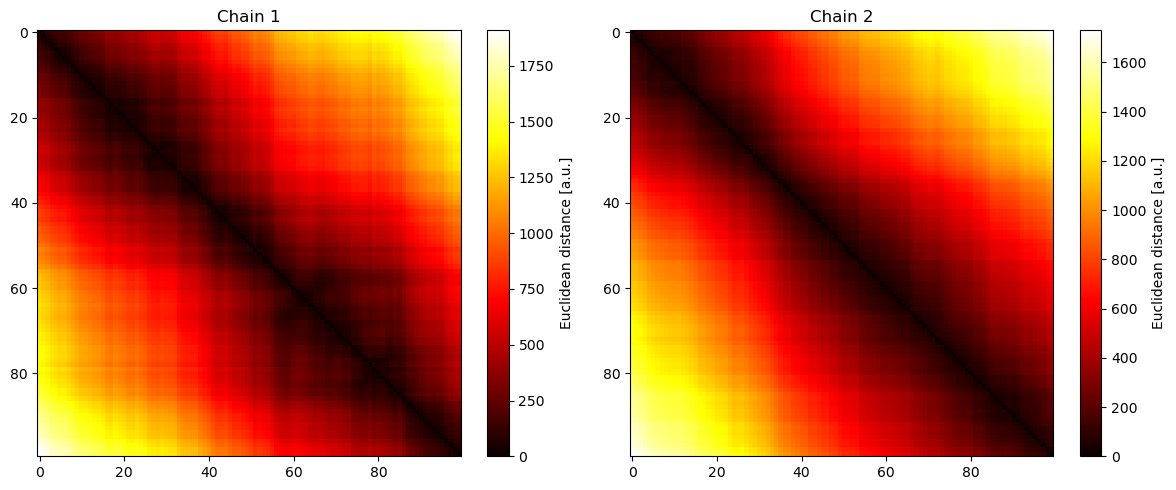

In [145]:
compare_distance_maps(pg_sol.params[0], pg_sol.params[1], type1='flatten_distance_map', type2='flatten_distance_map')

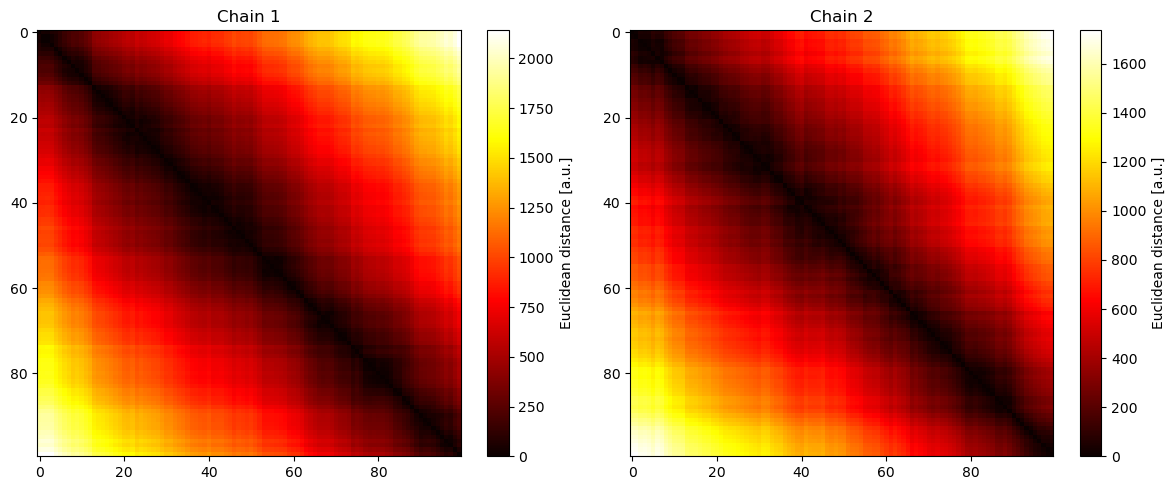

In [128]:
compare_distance_maps(candidate_flatten_list[0], candidate_flatten_list[1], type1='flatten_distance_map', type2='flatten_distance_map')

In [24]:
true_means = np.array(templates_flatten)
pred_means = np.array(pg_sol.params)

In [25]:
# Let's assign the labels to the pg_sol
true_idx, pred_idx = assign_clusters(true_means, pred_means, True)

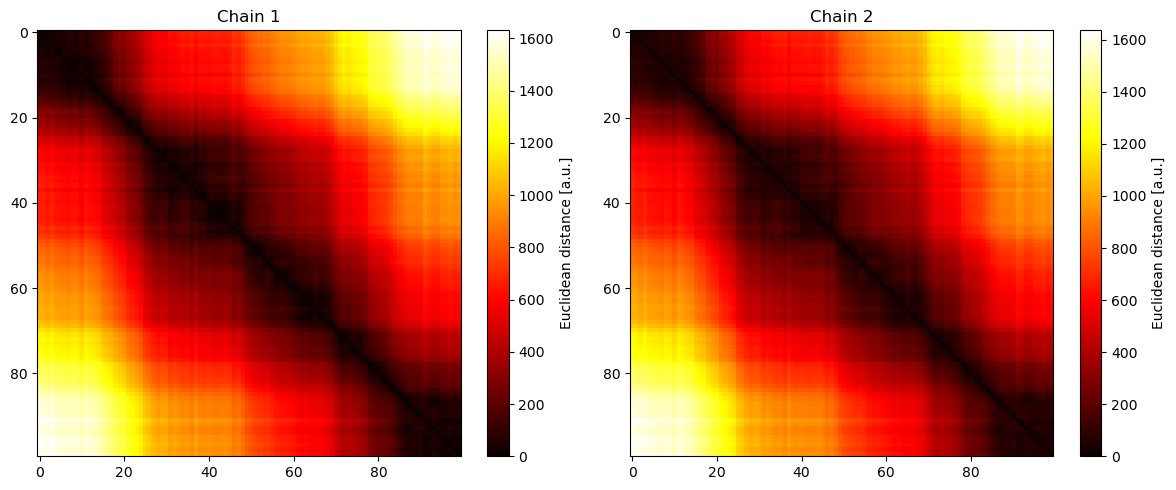

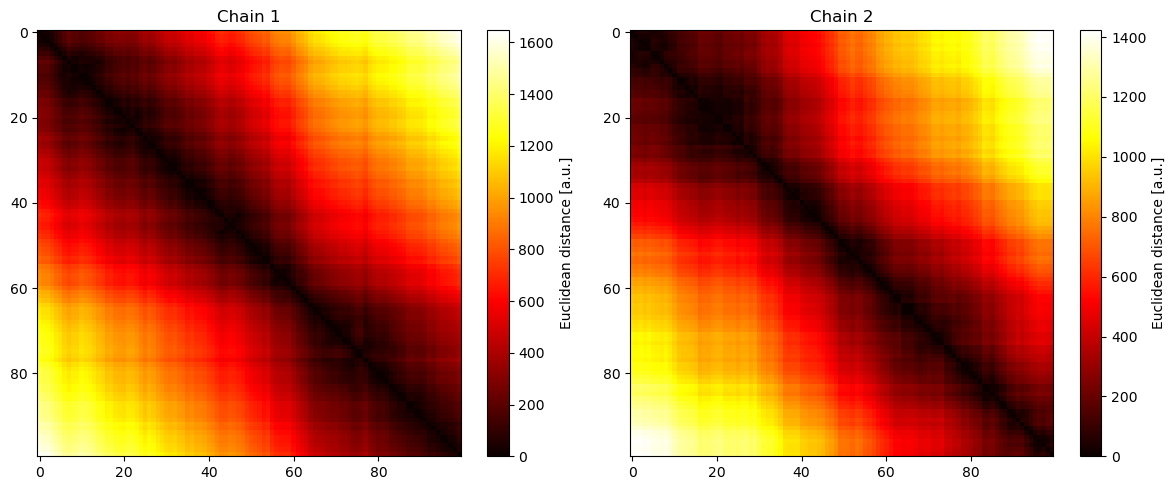

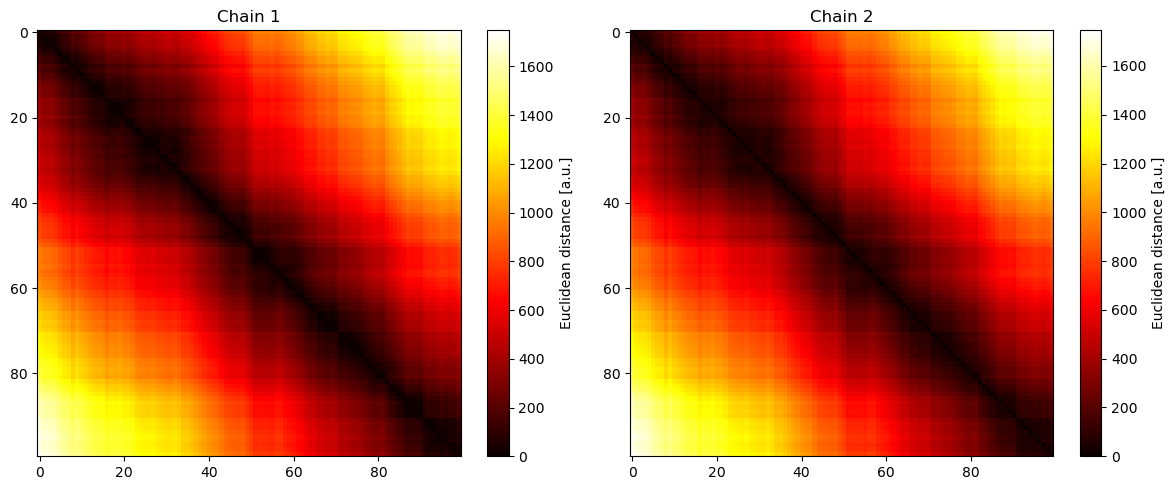

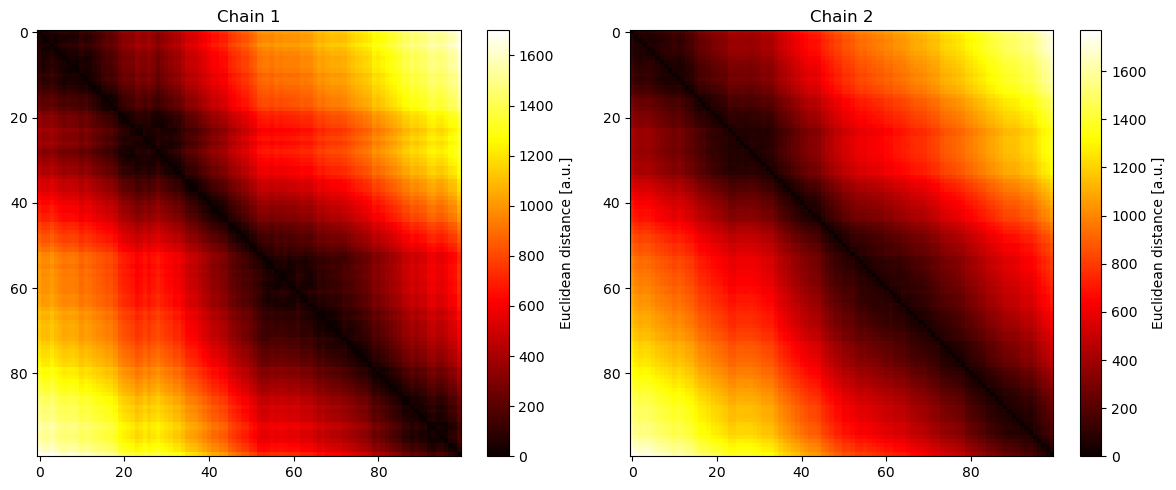

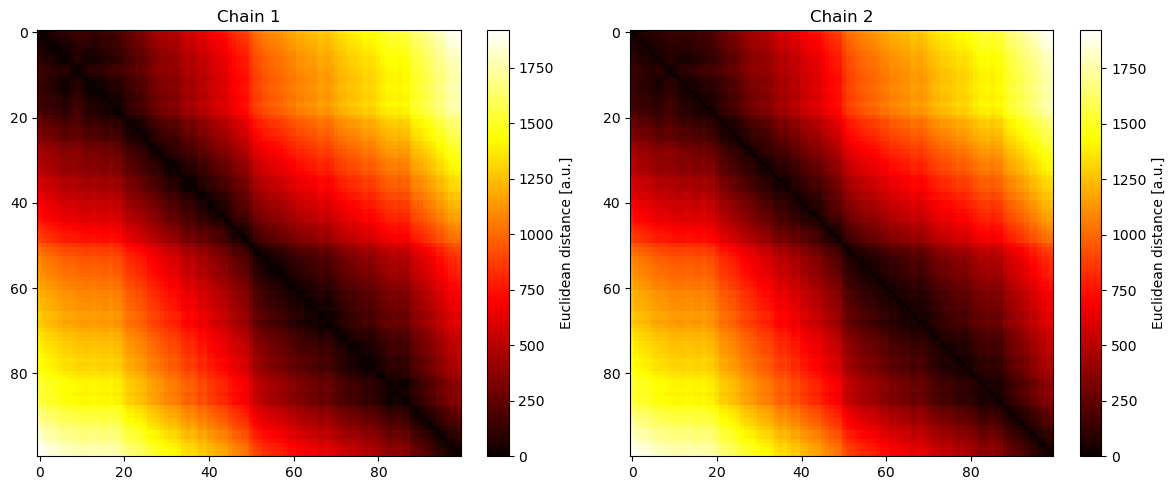

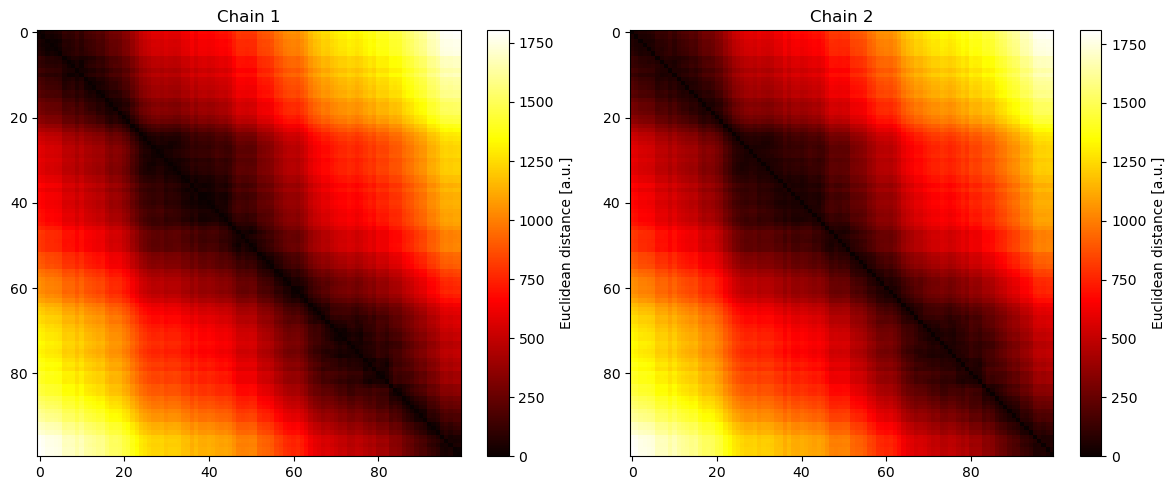

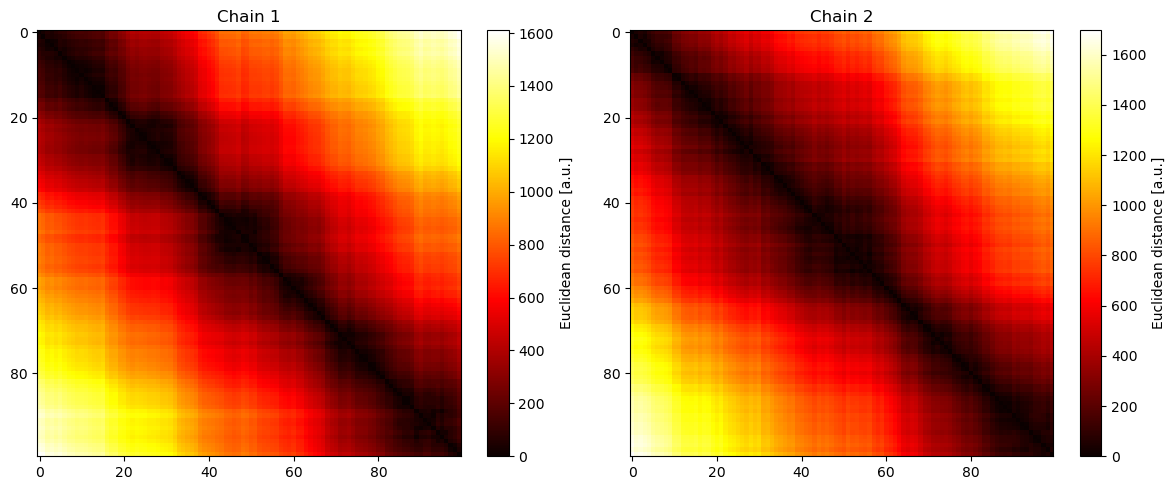

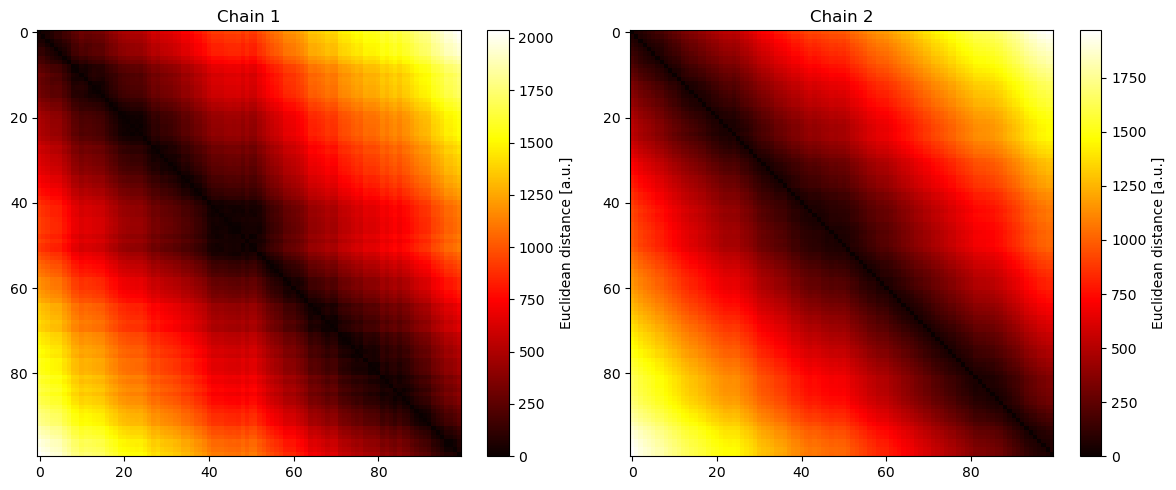

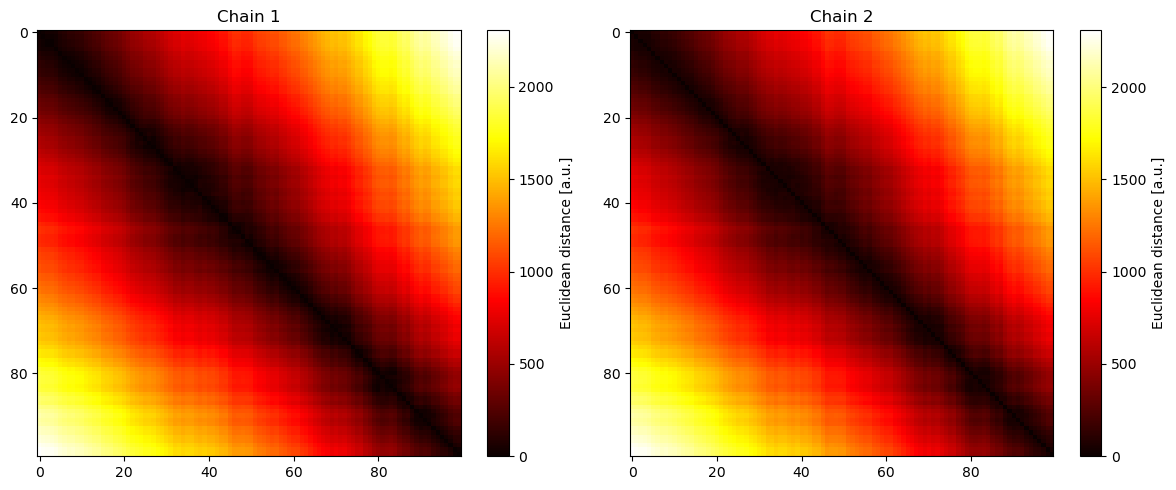

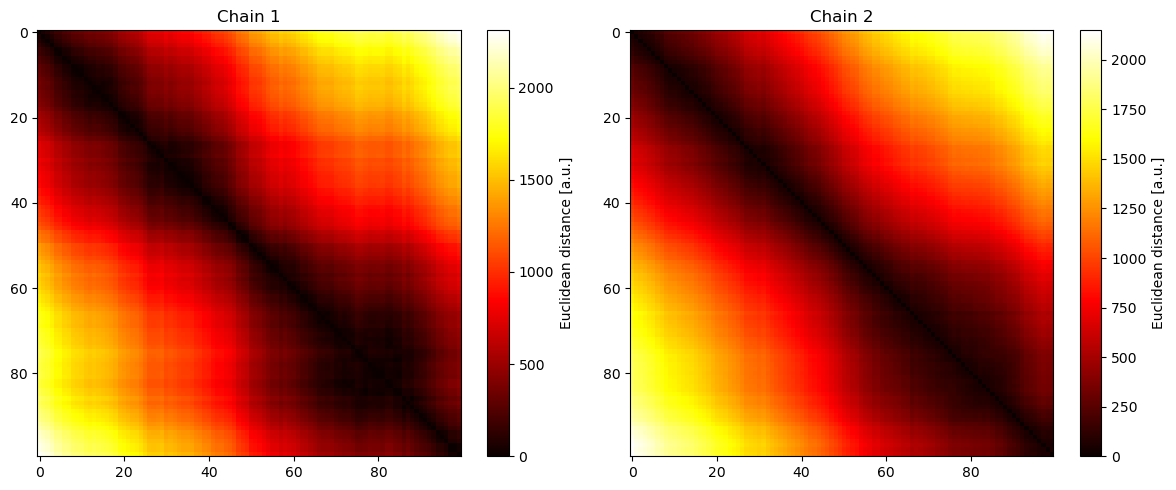

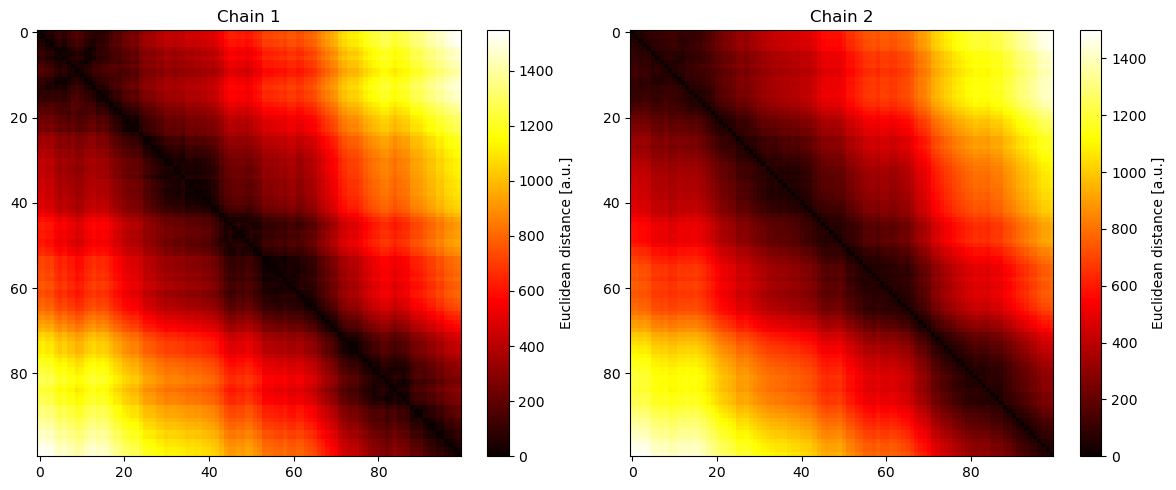

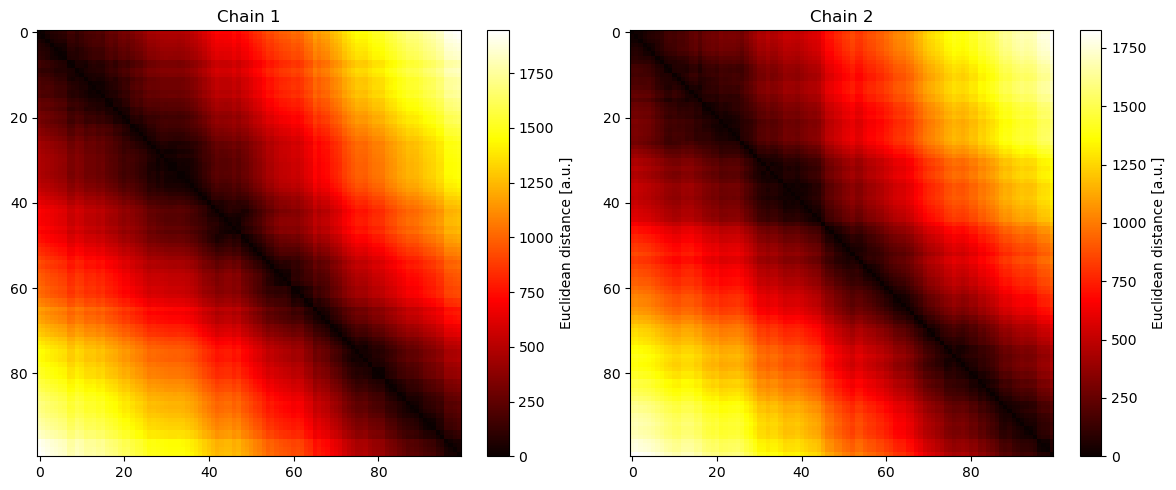

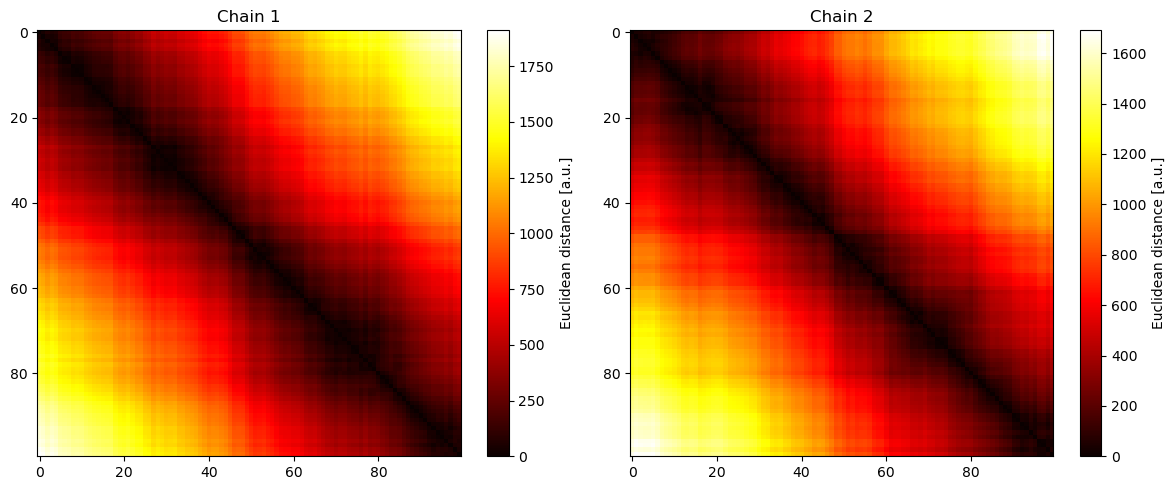

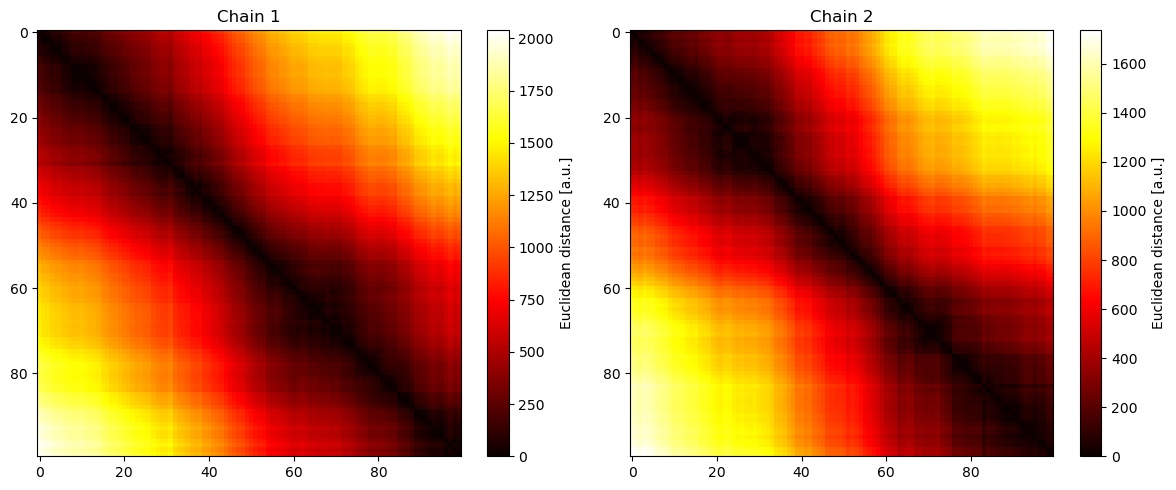

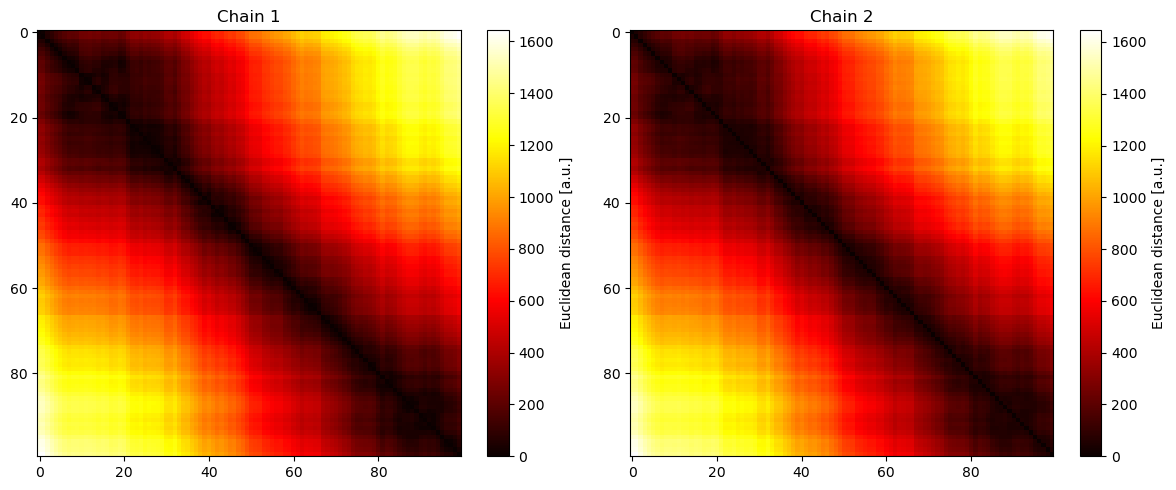

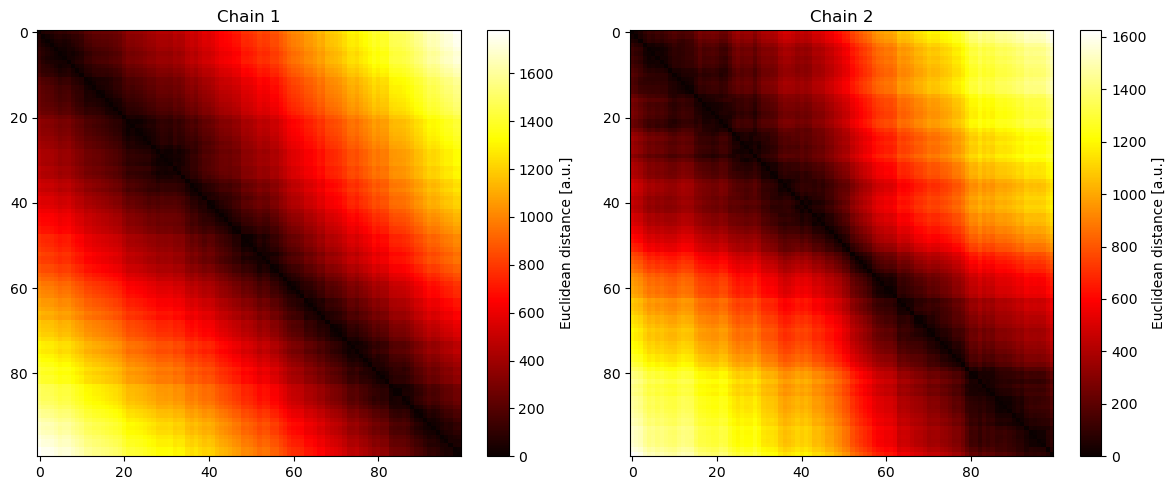

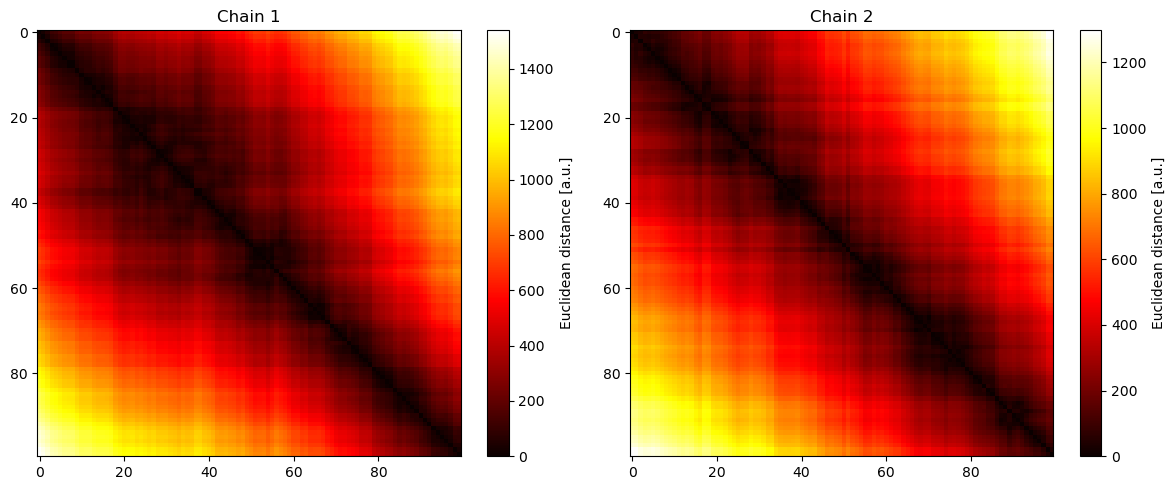

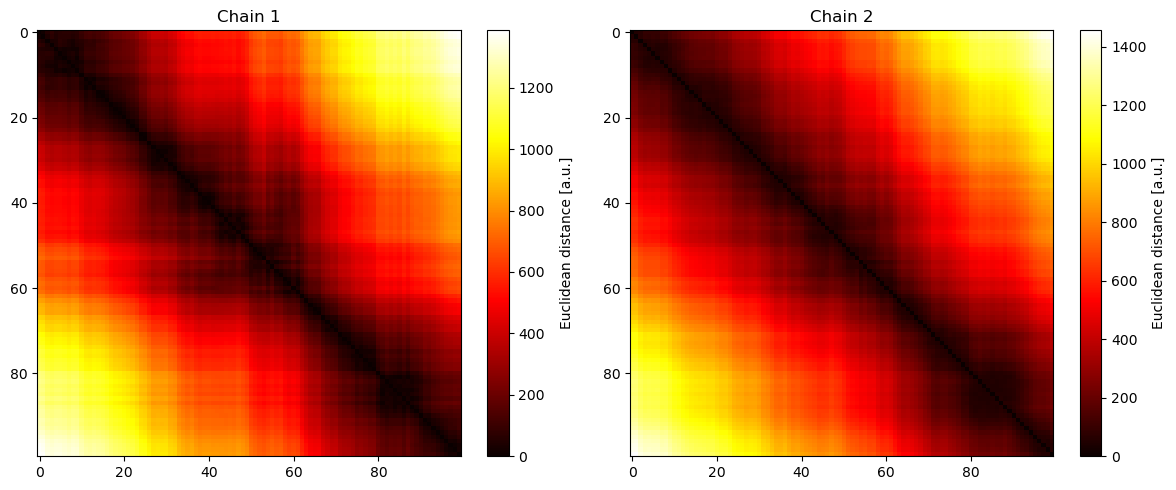

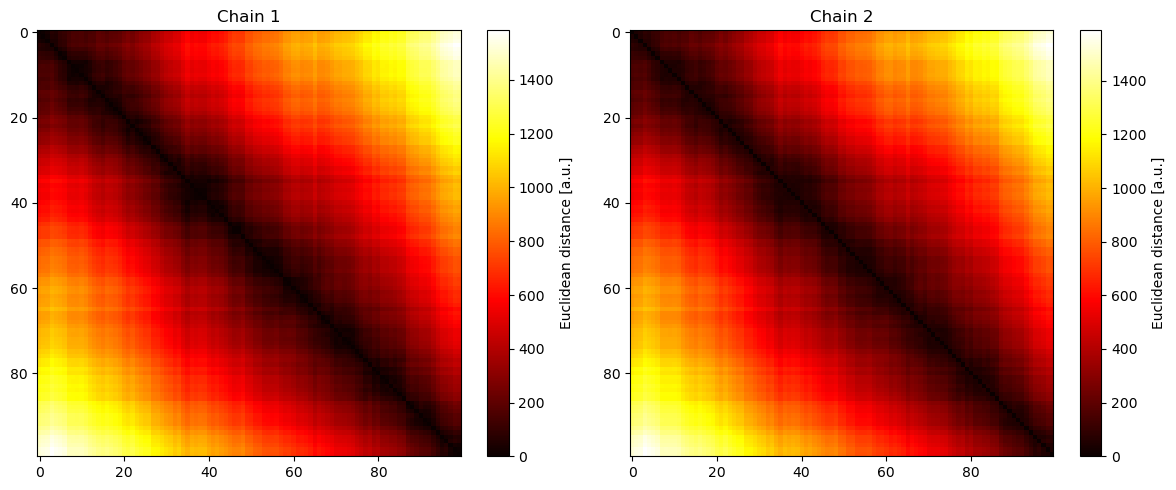

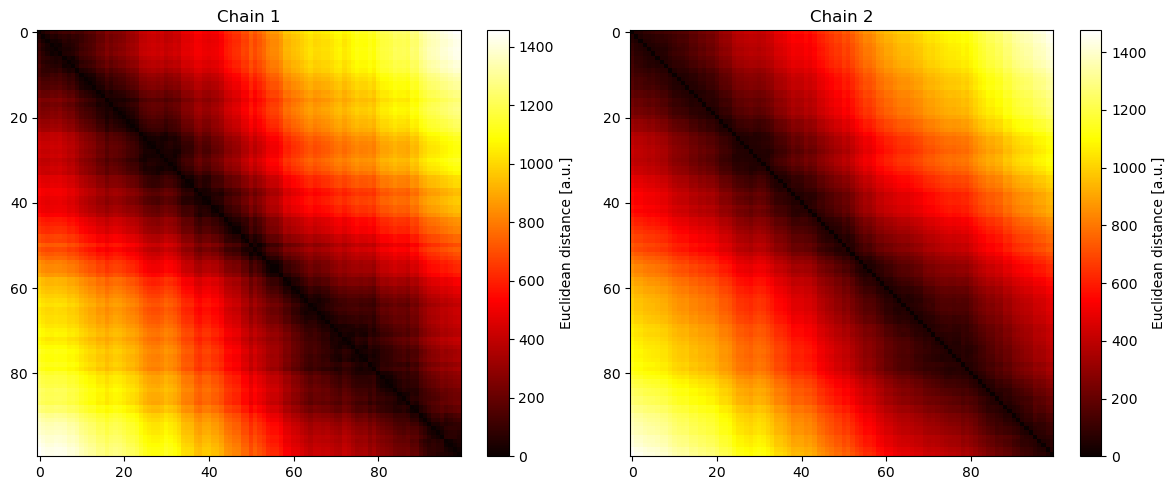

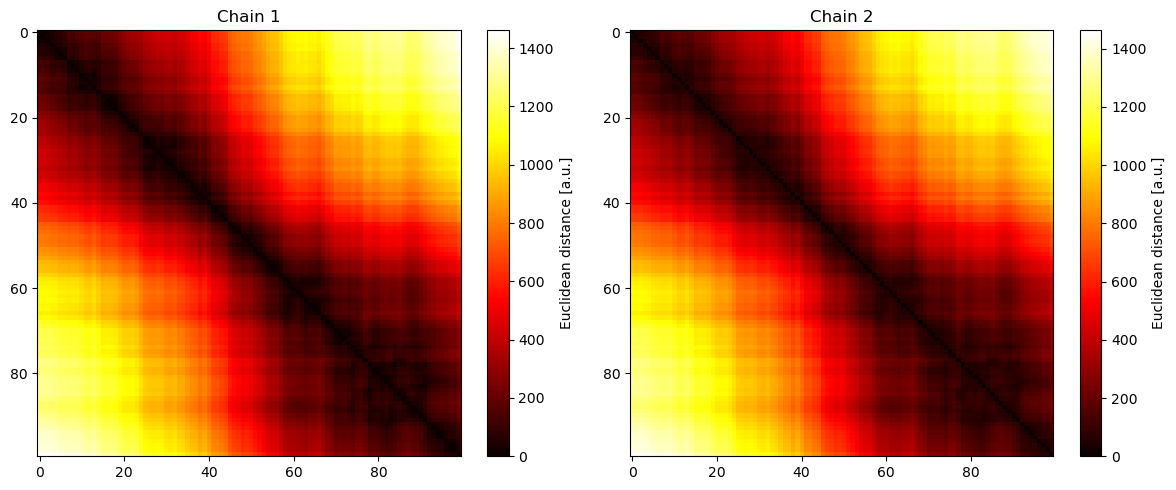

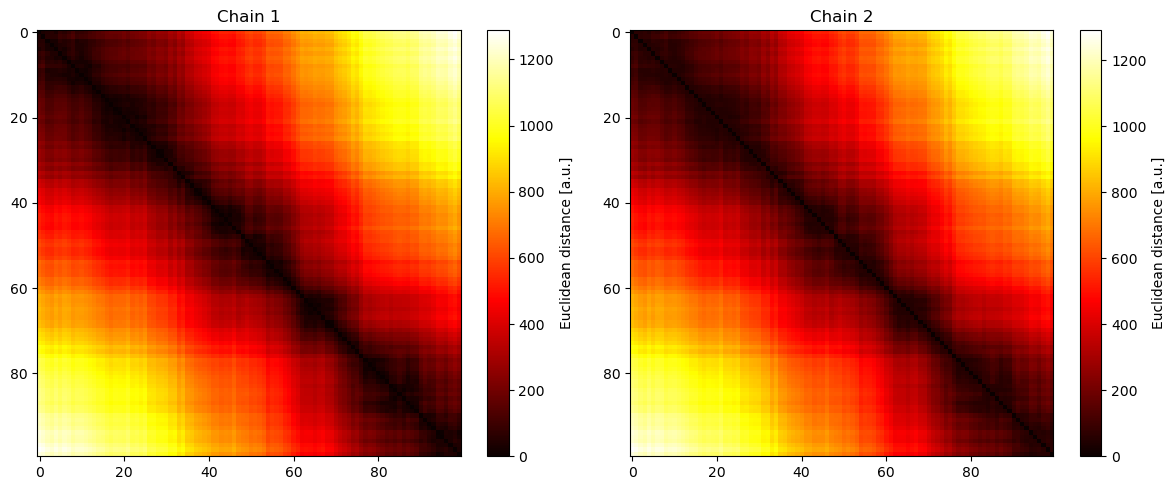

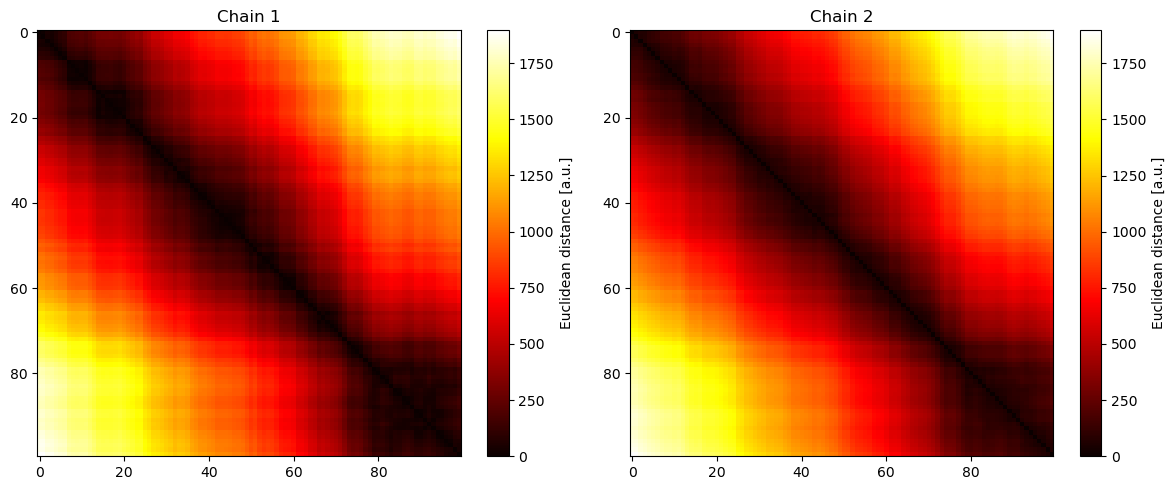

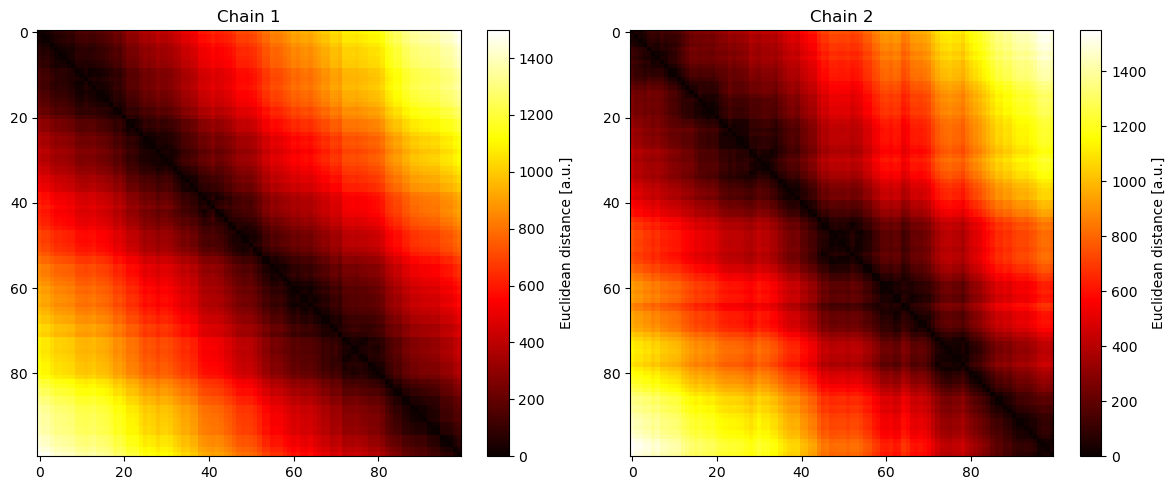

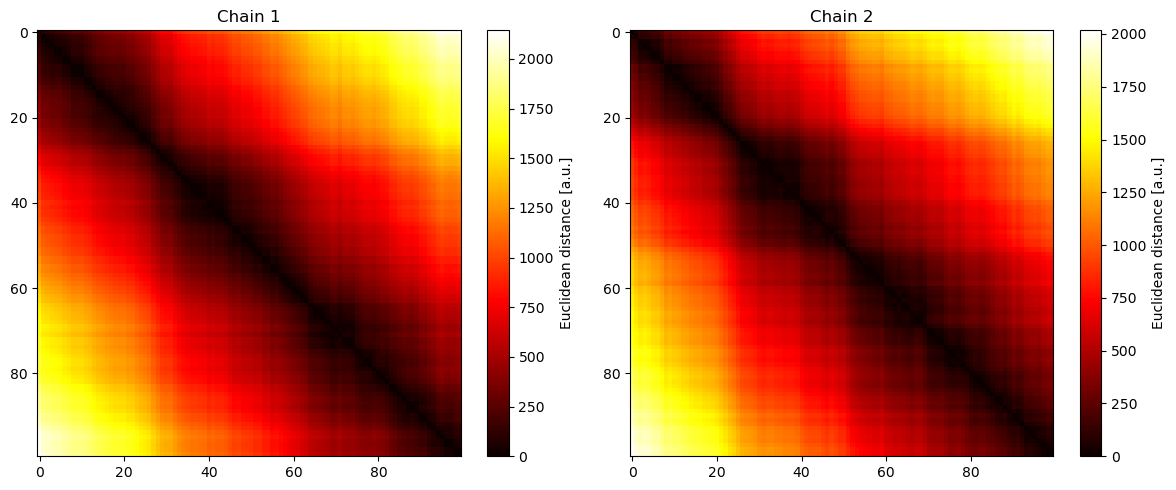

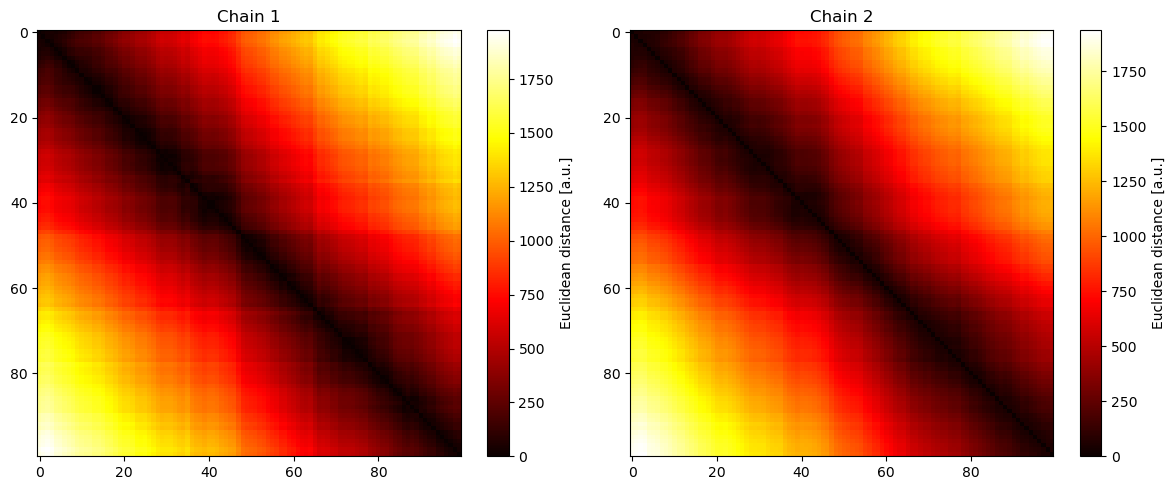

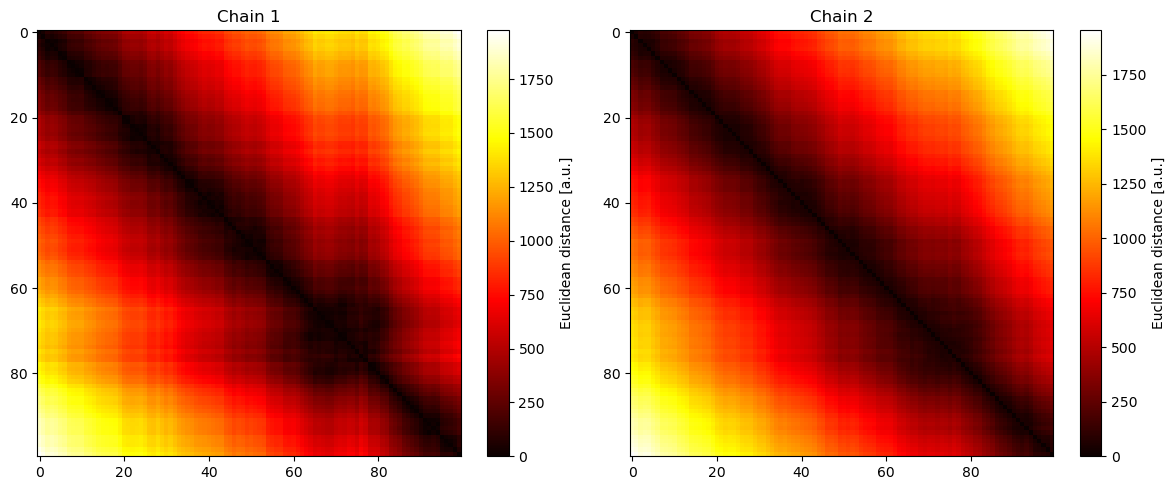

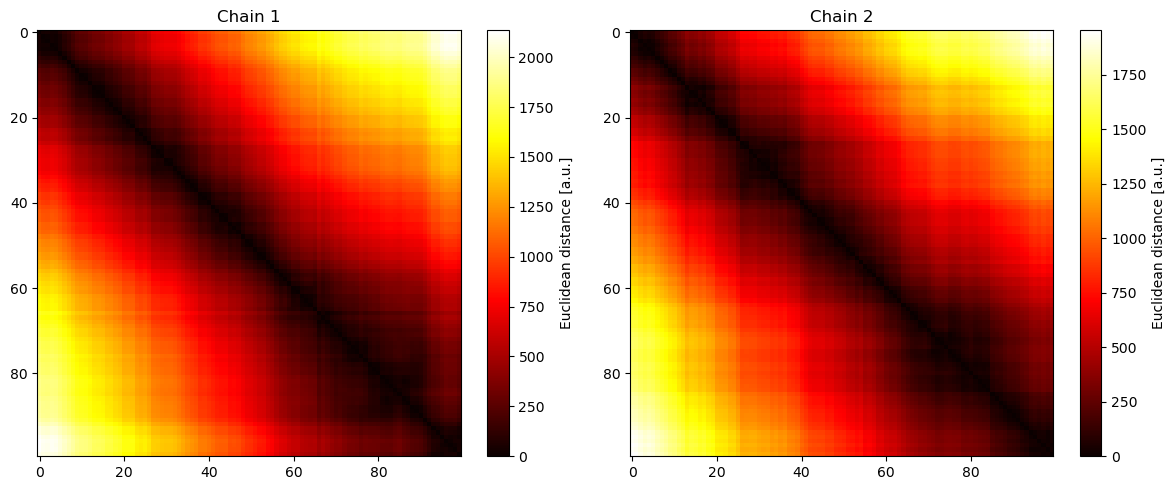

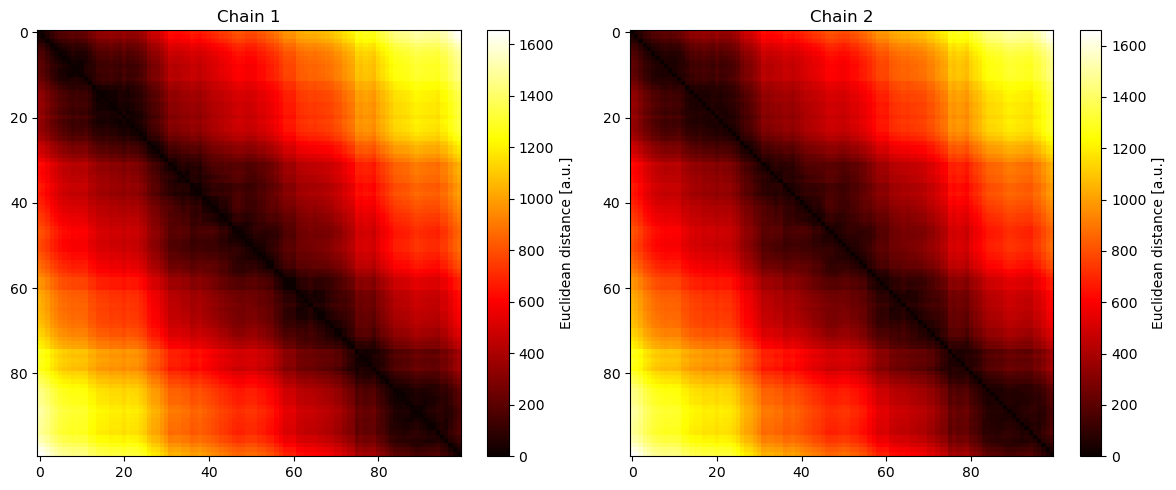

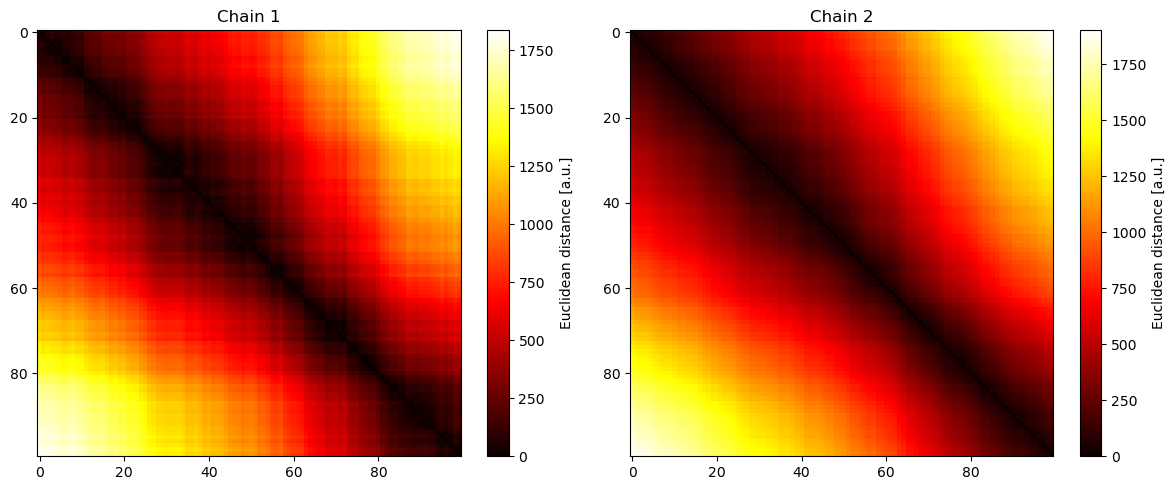

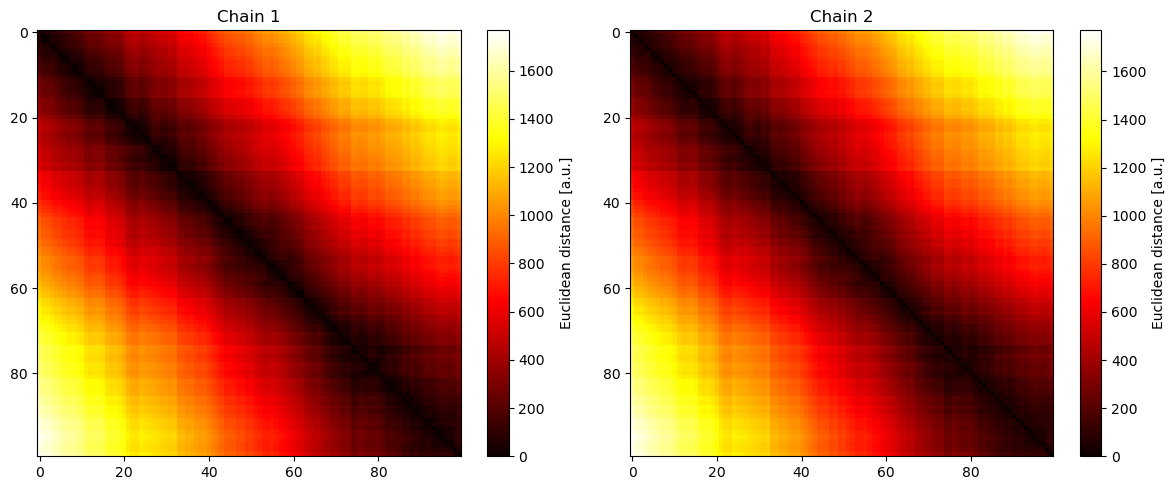

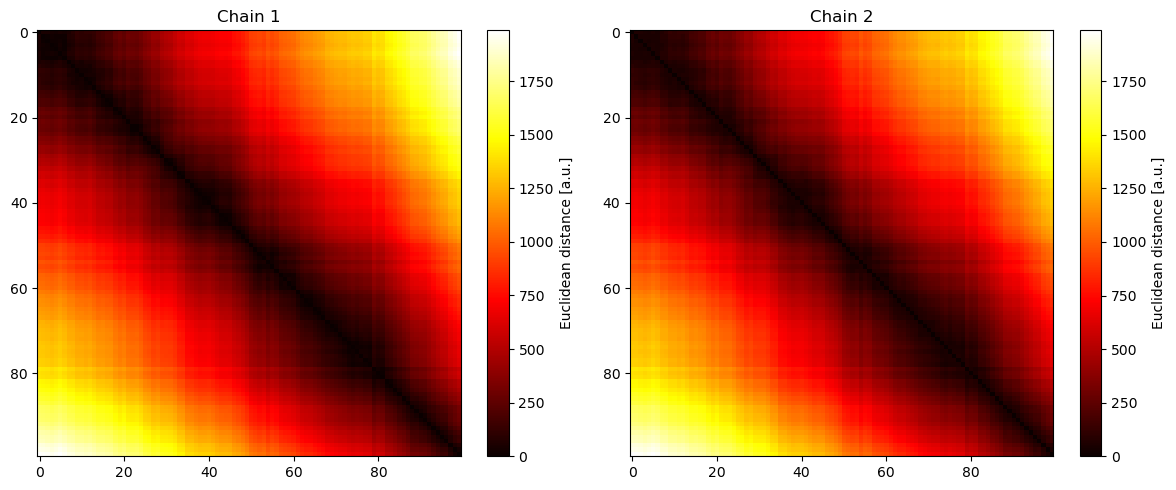

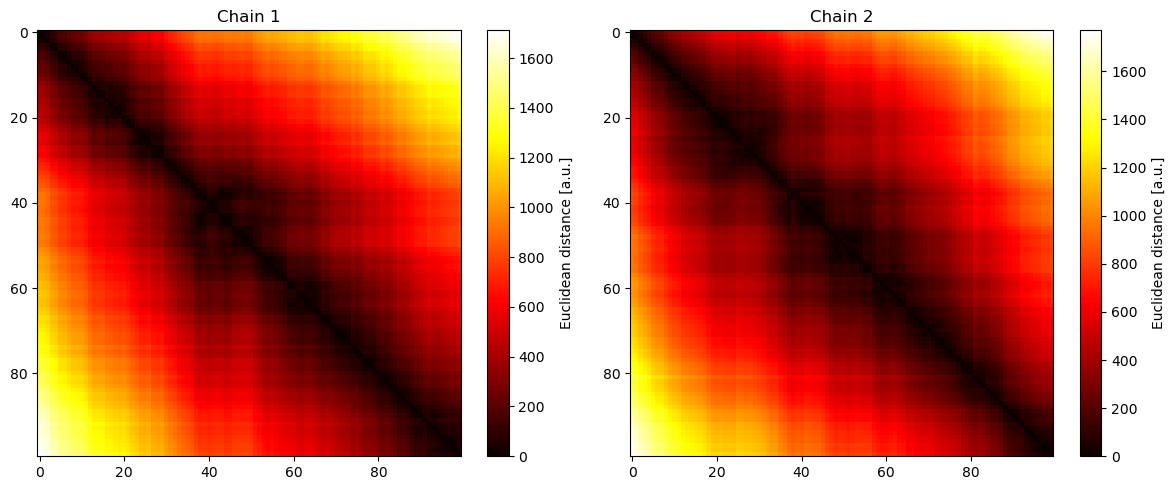

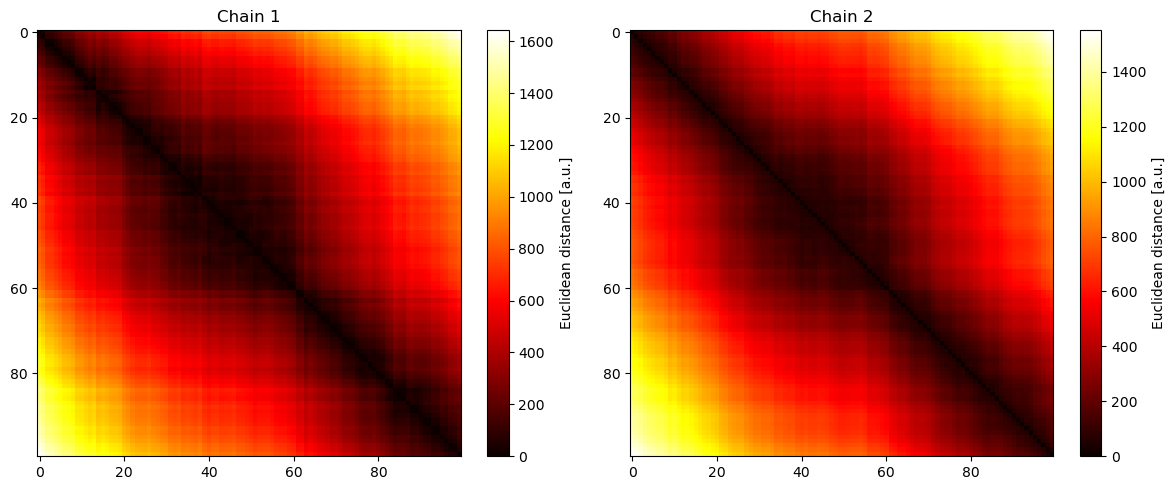

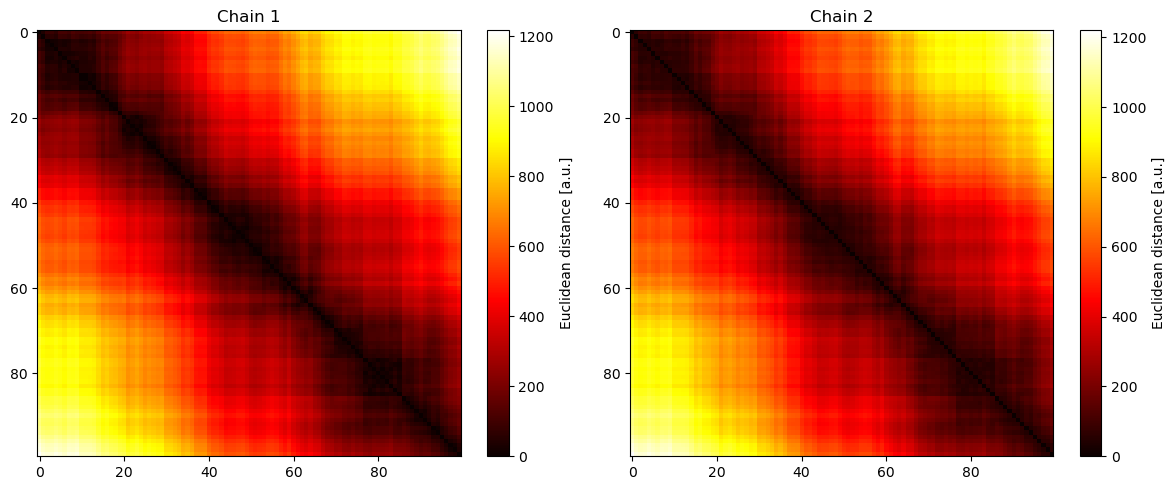

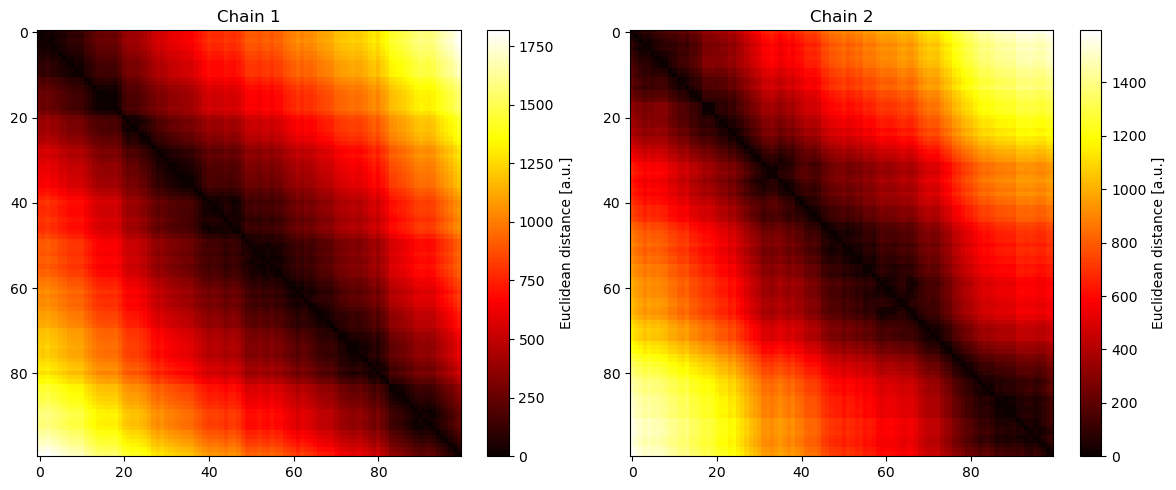

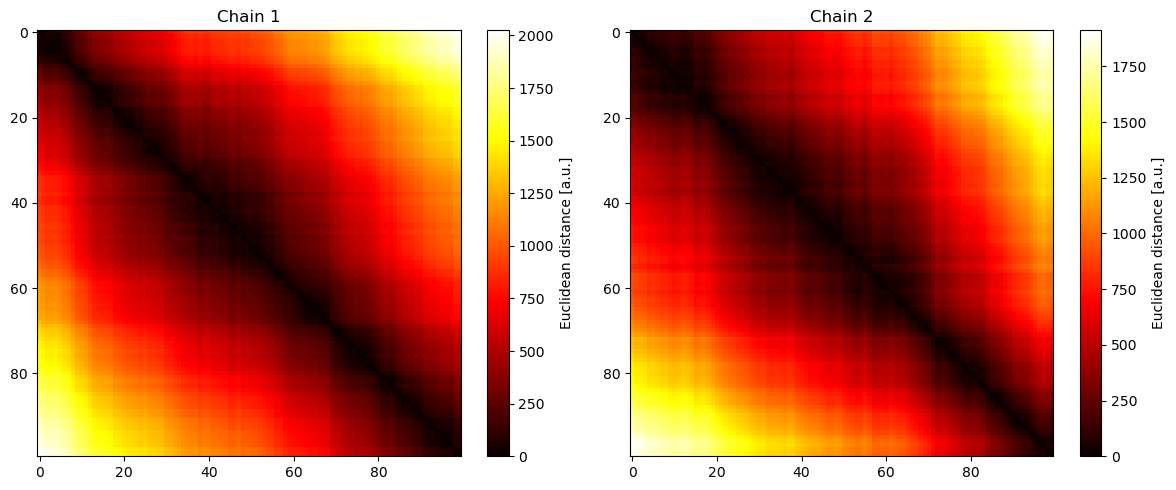

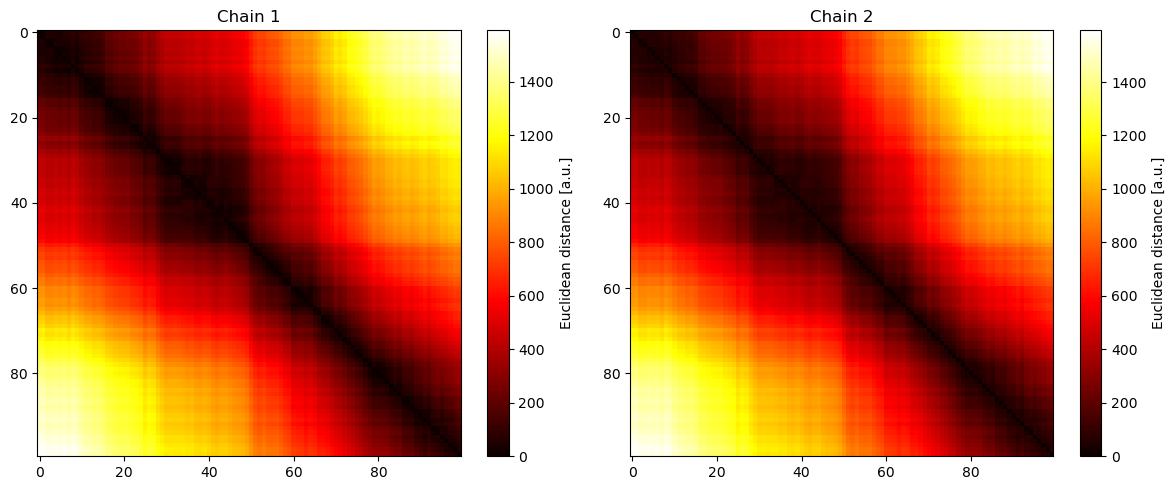

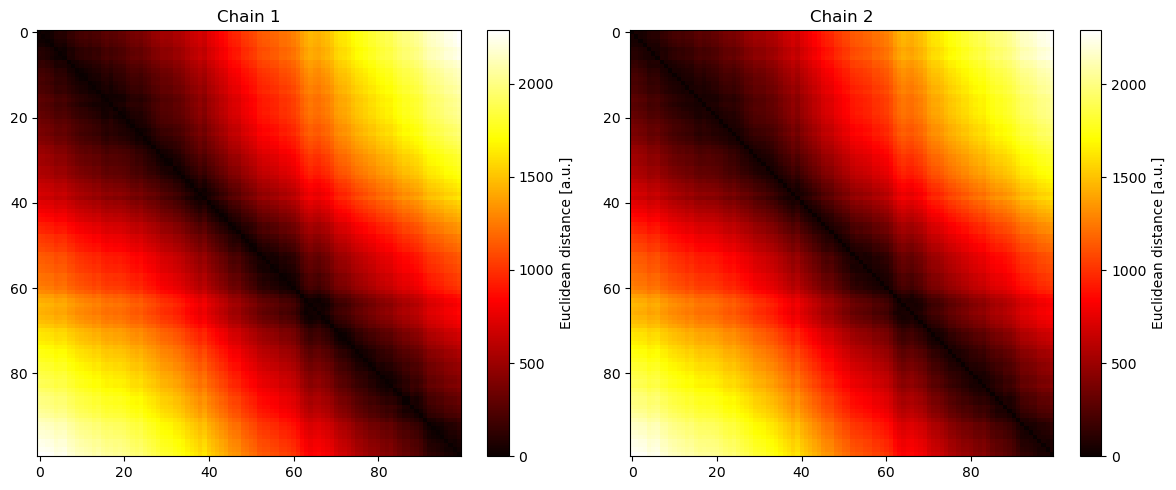

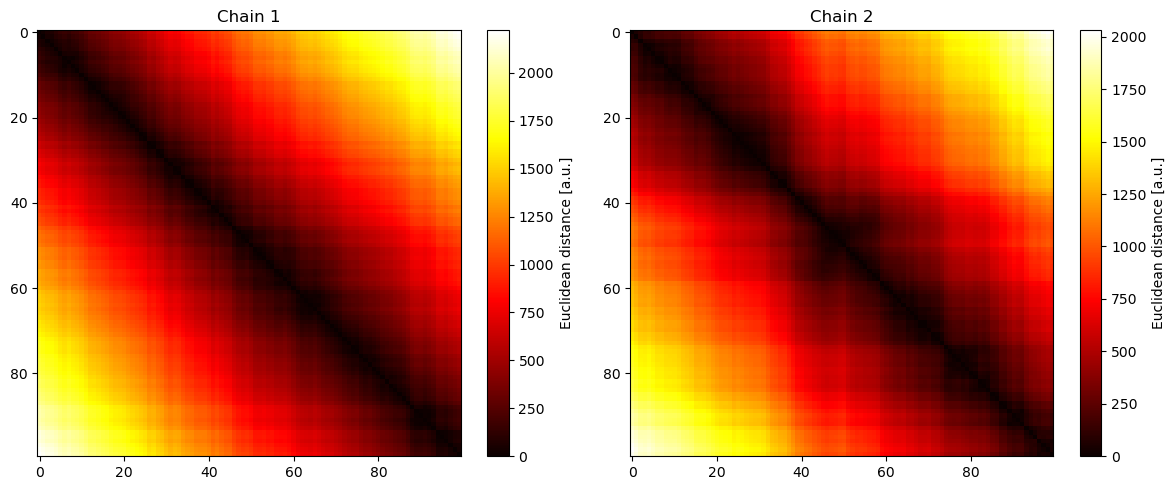

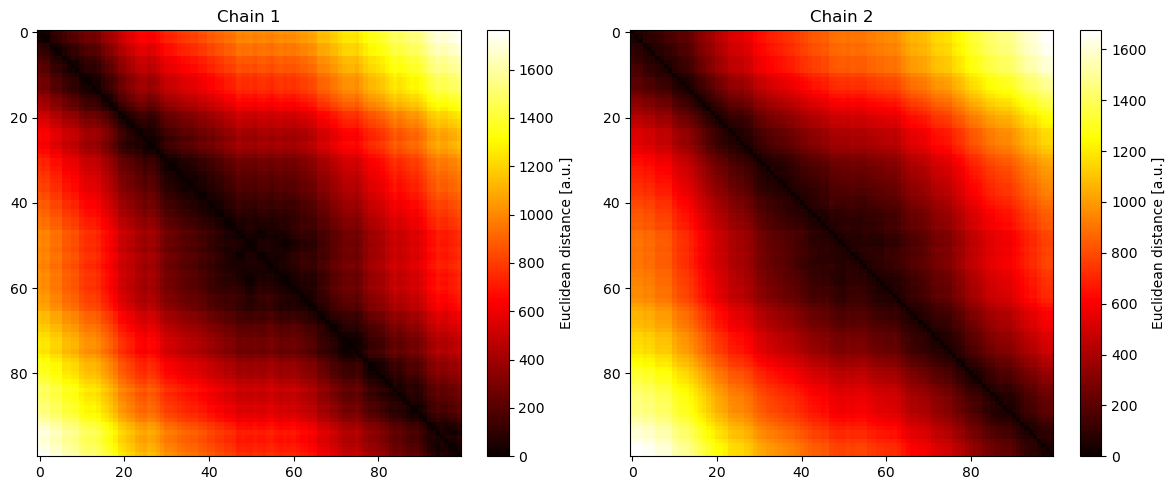

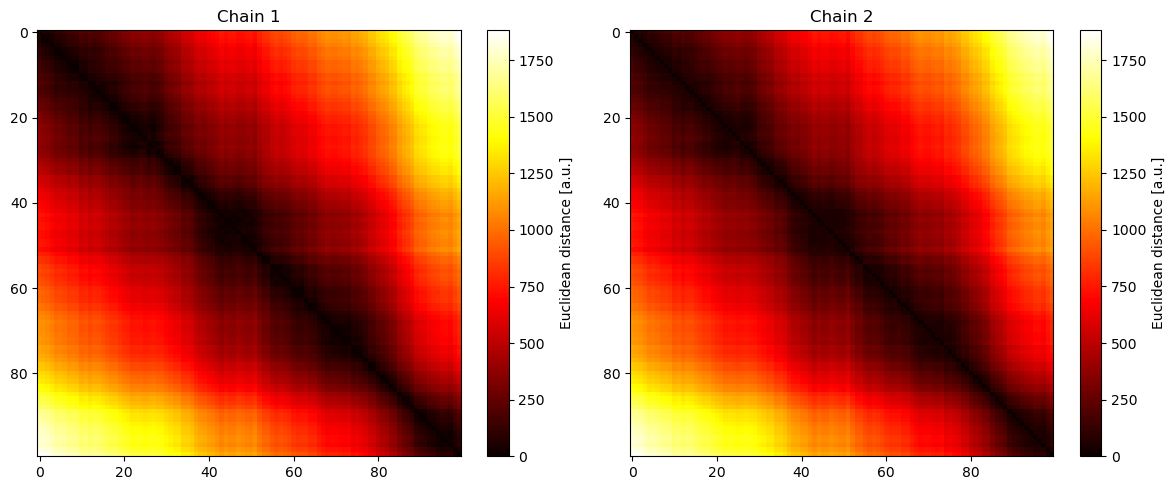

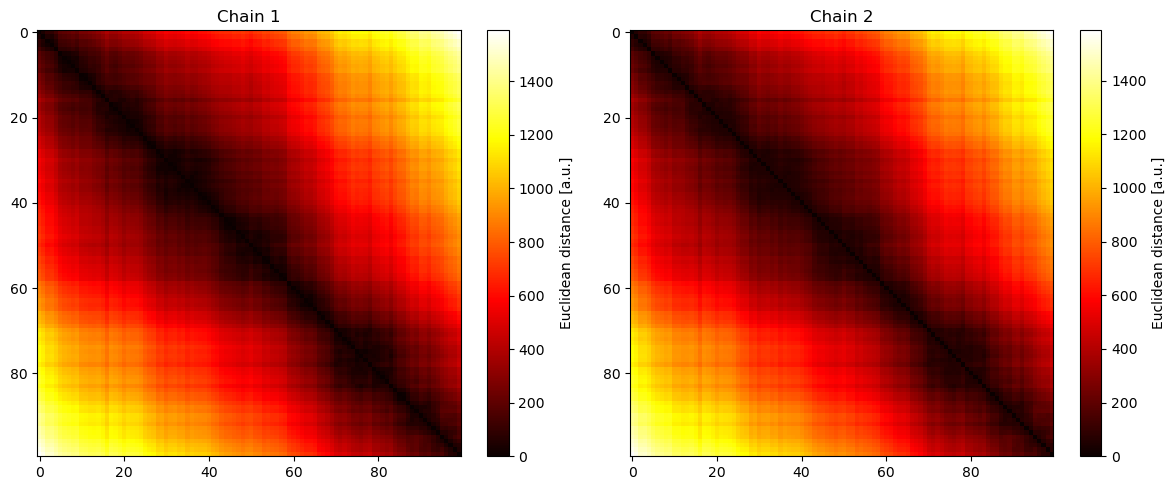

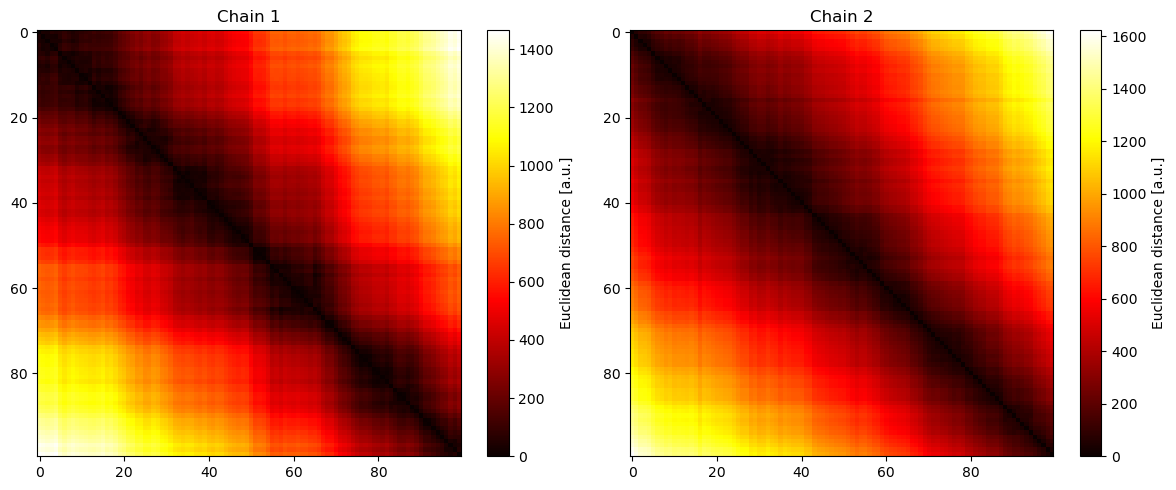

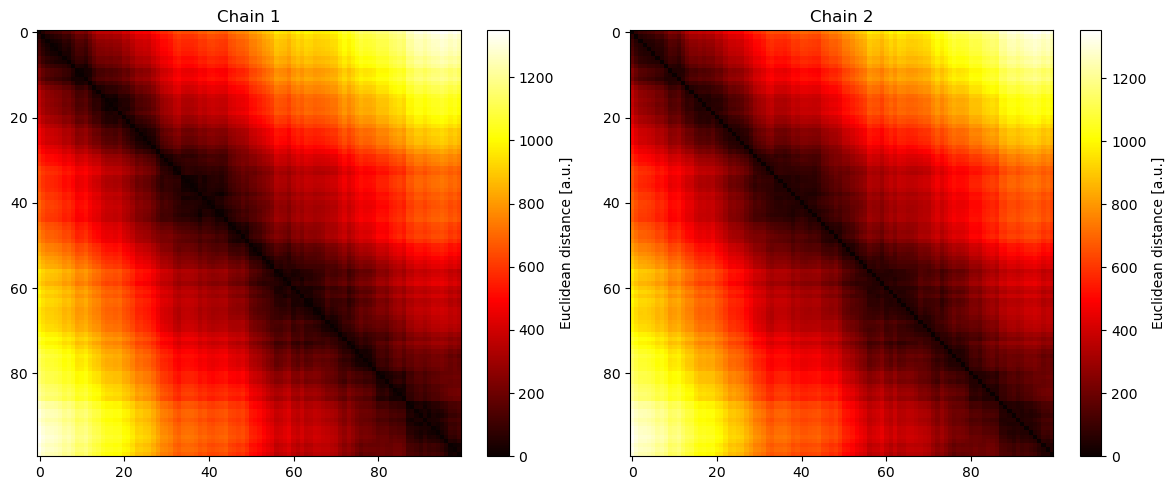

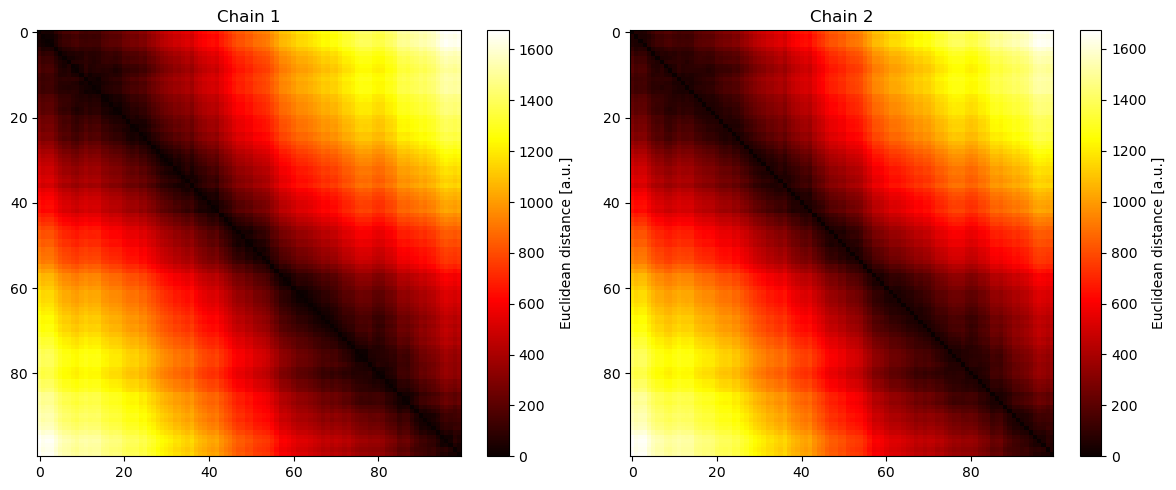

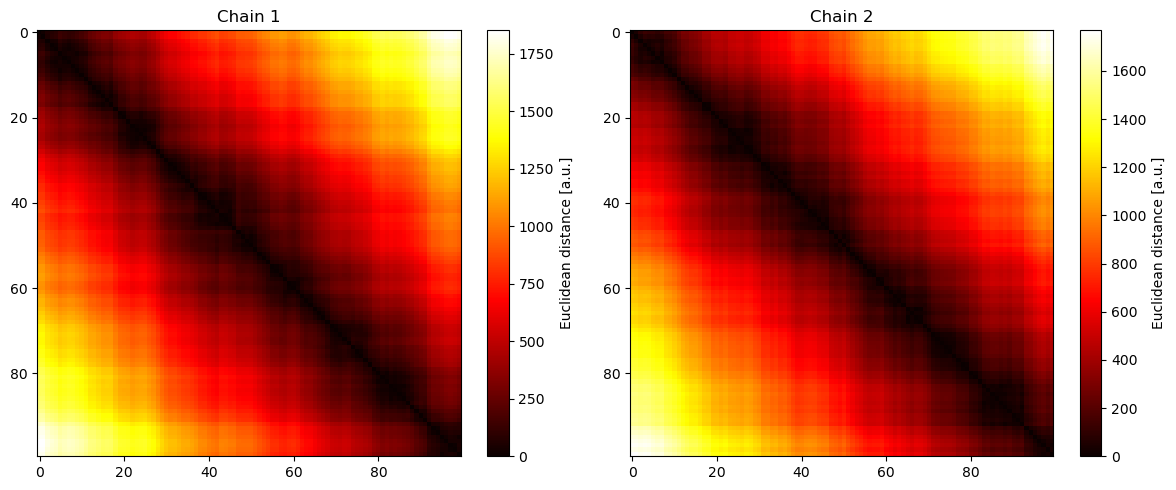

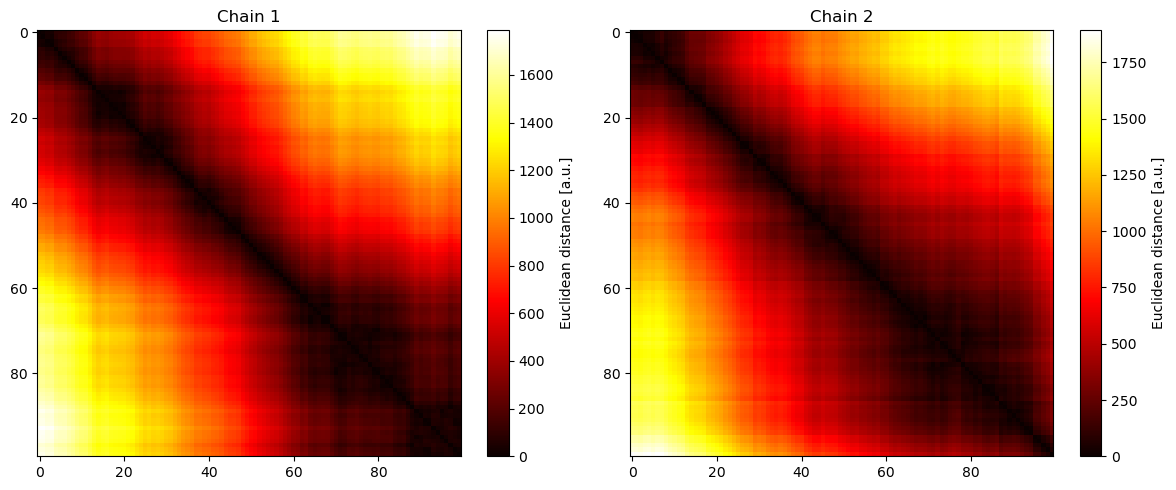

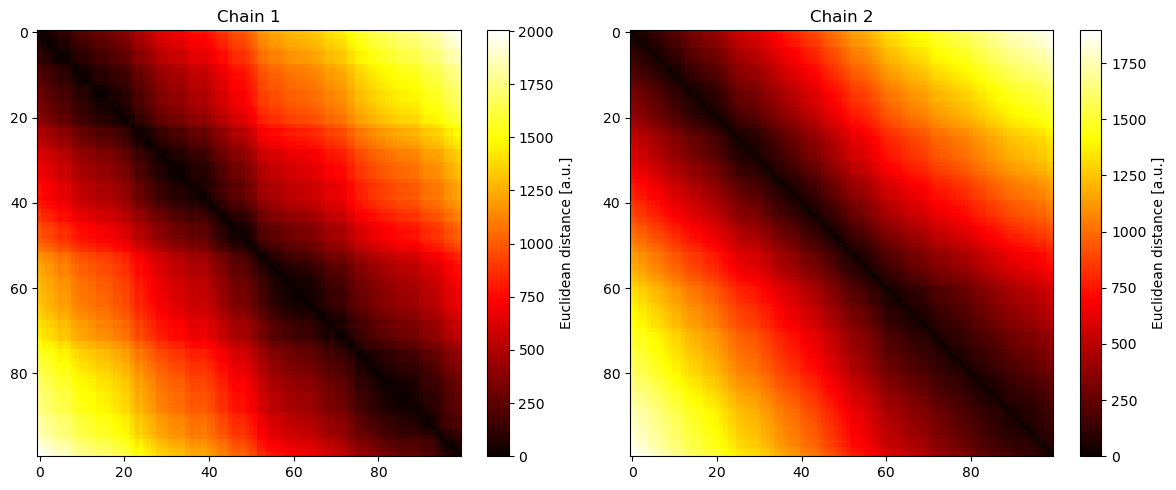

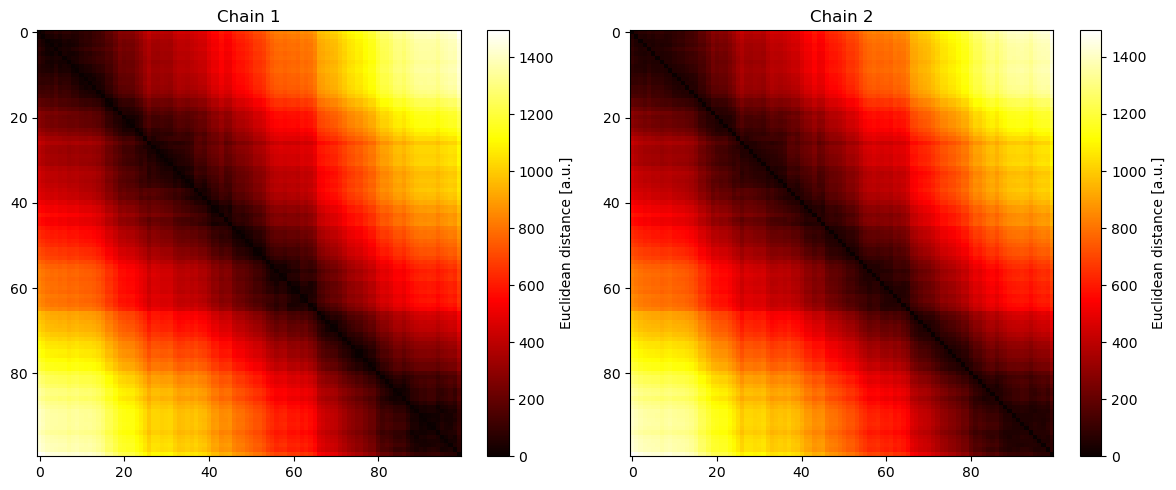

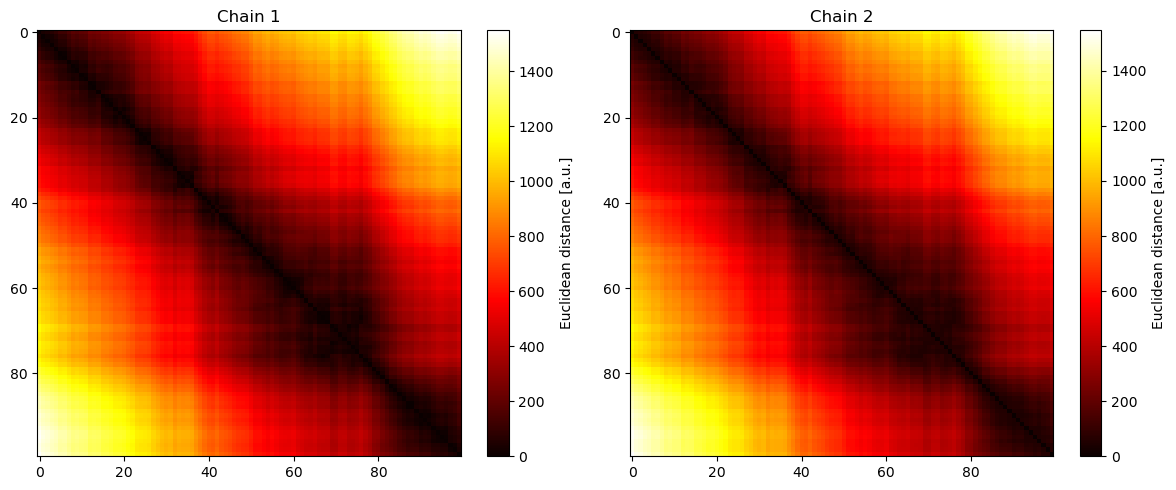

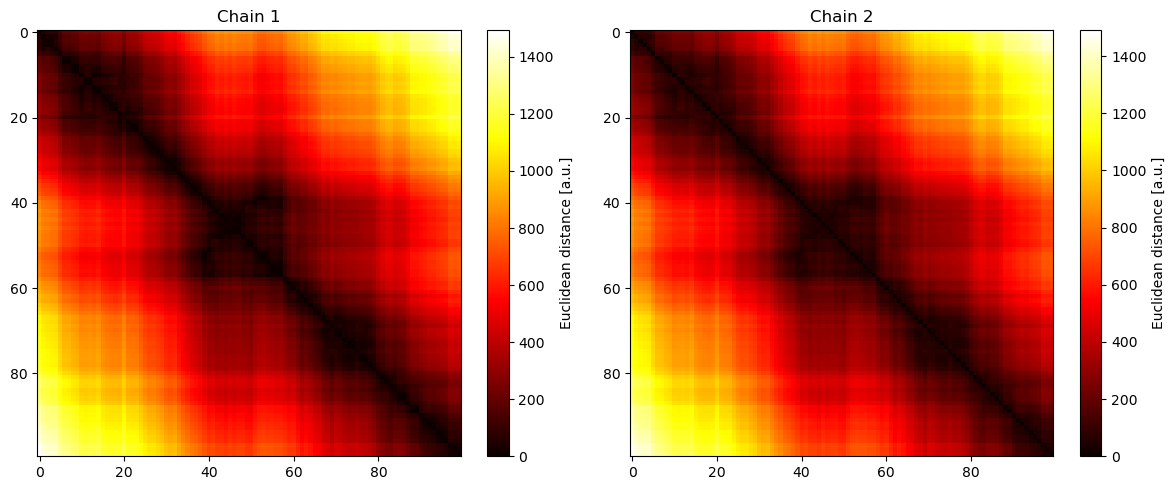

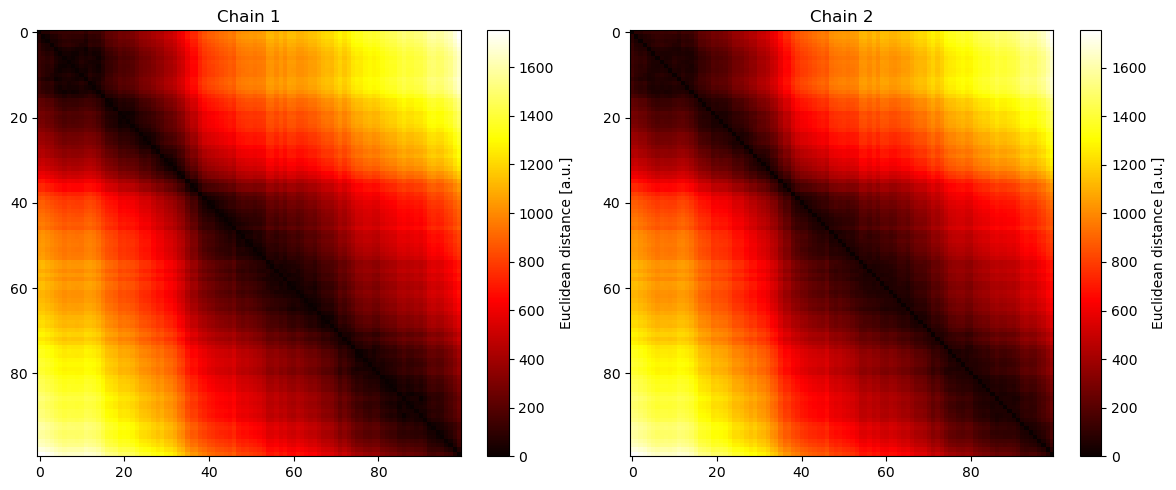

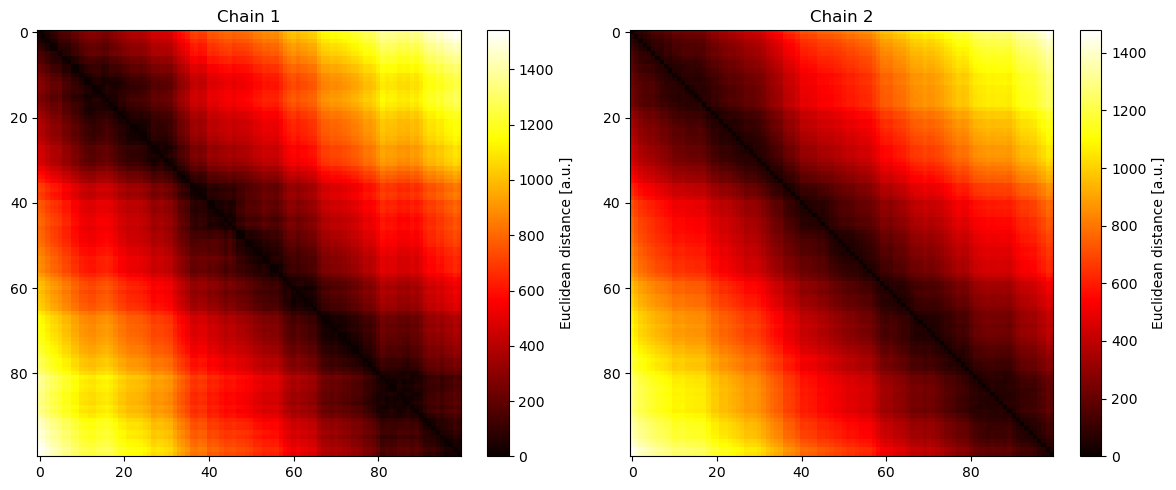

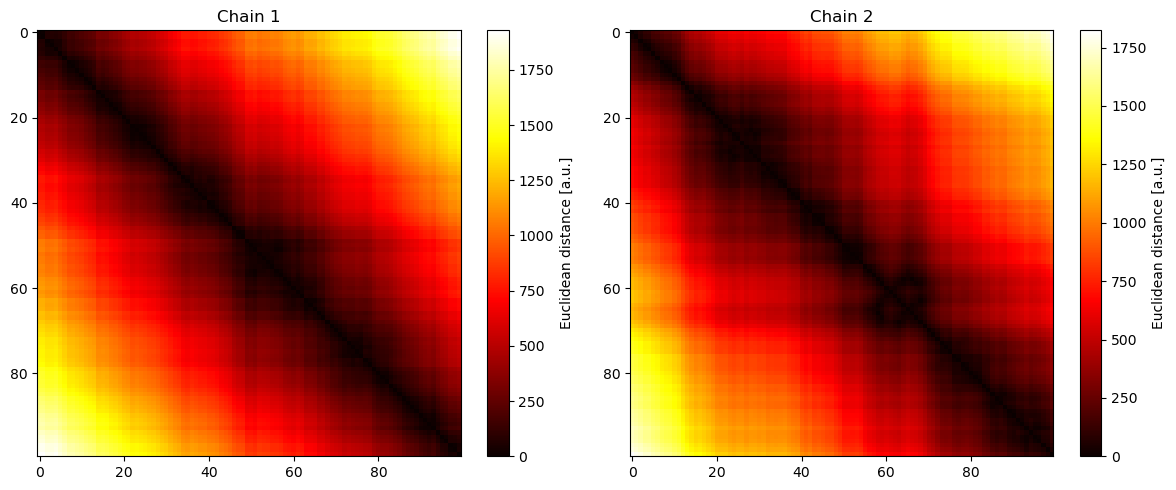

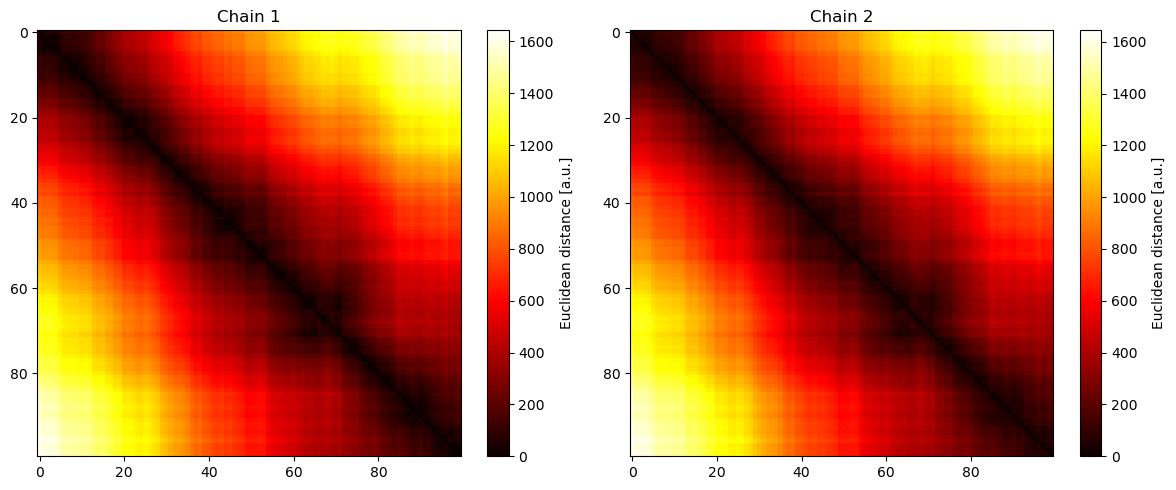

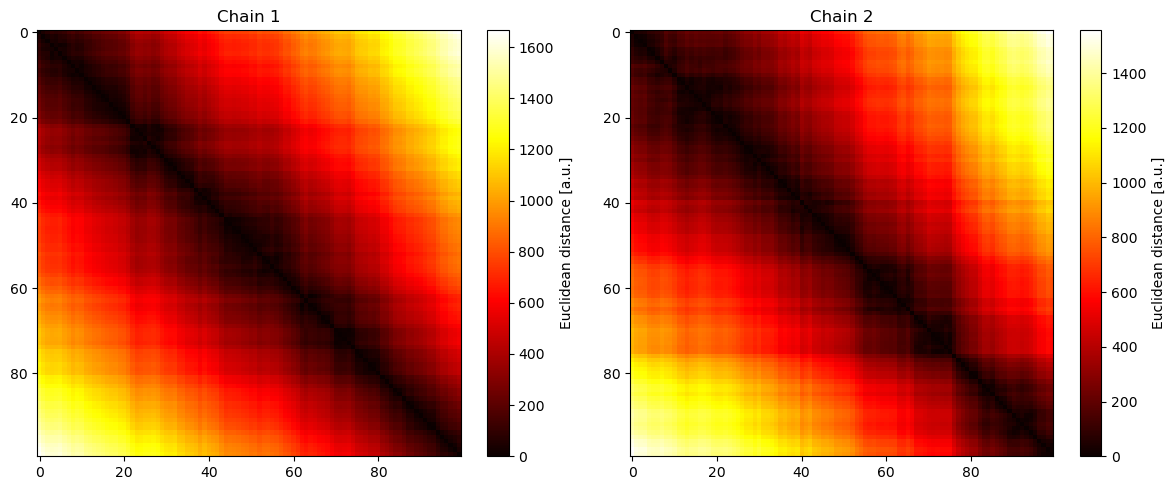

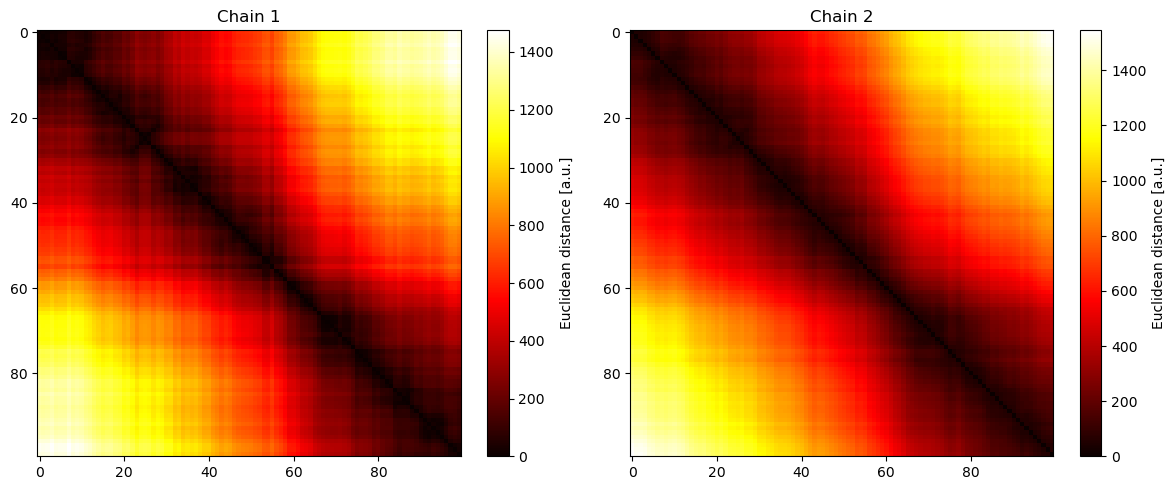

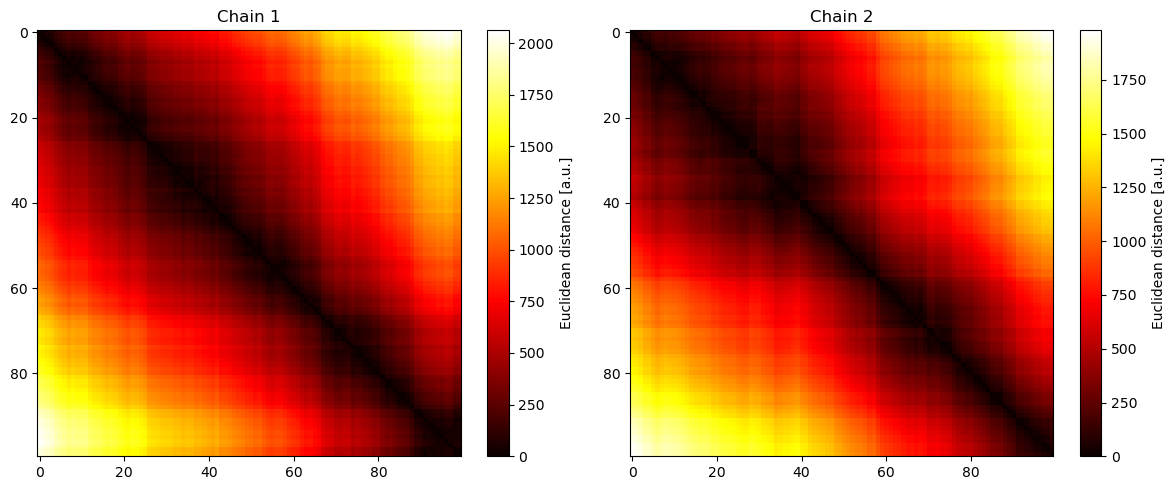

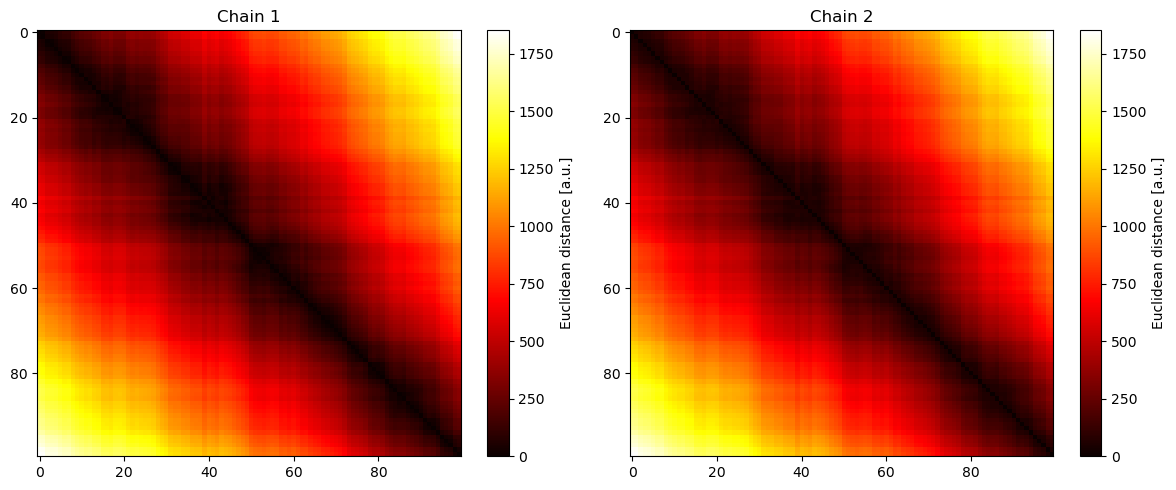

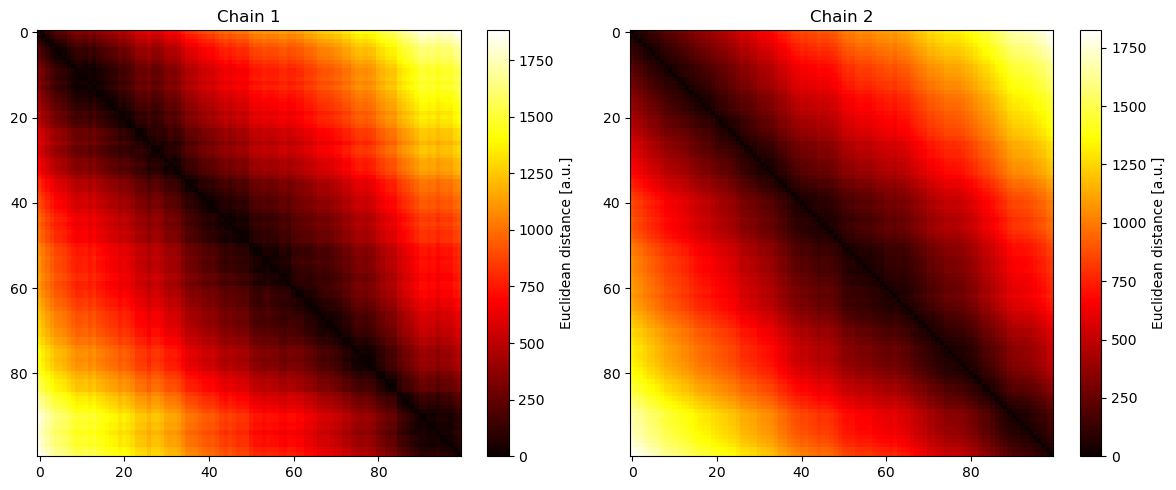

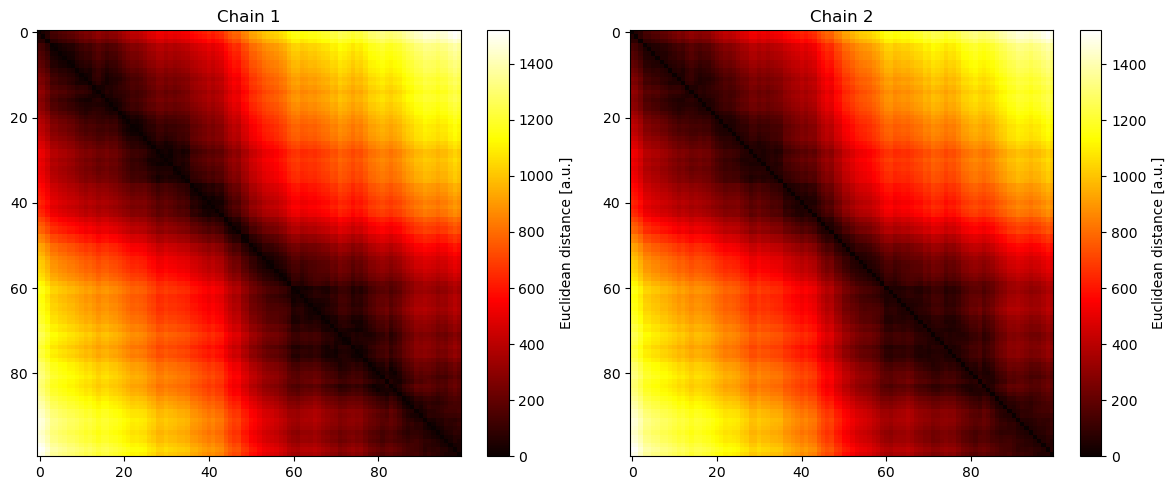

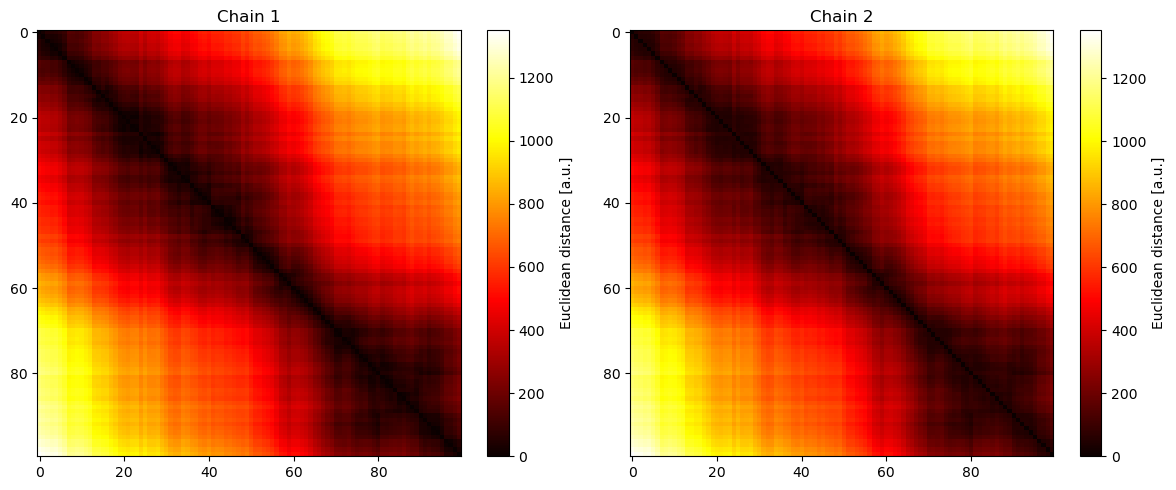

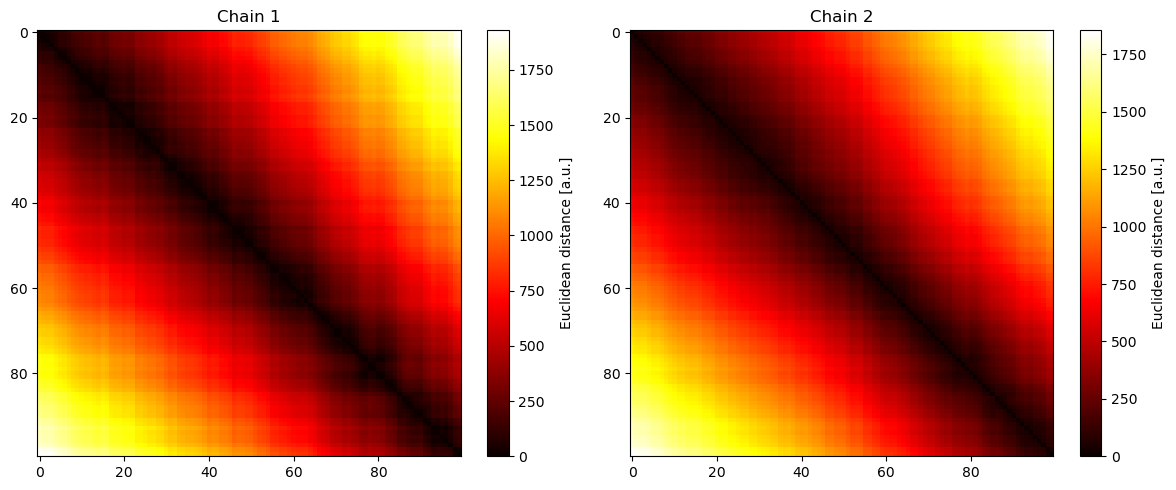

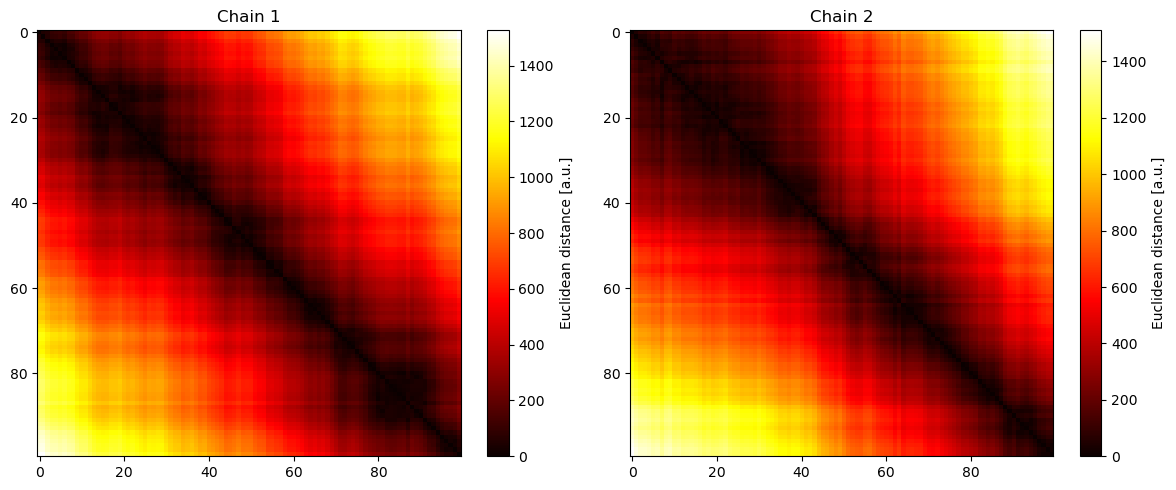

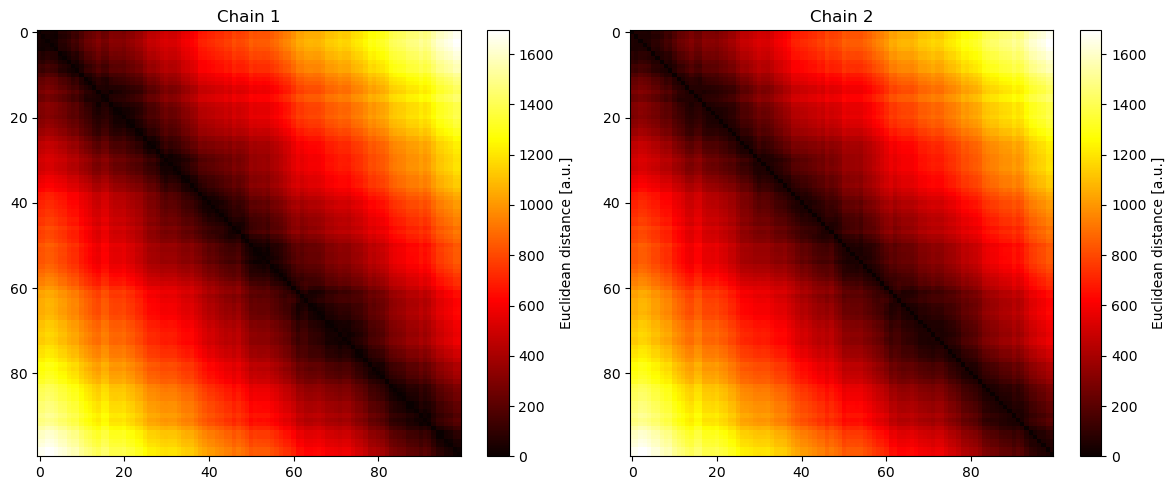

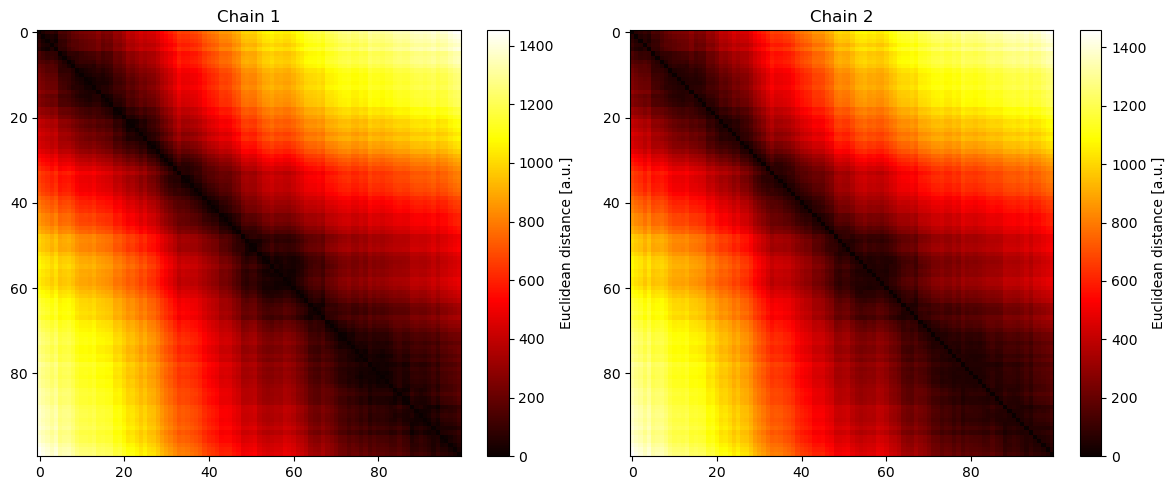

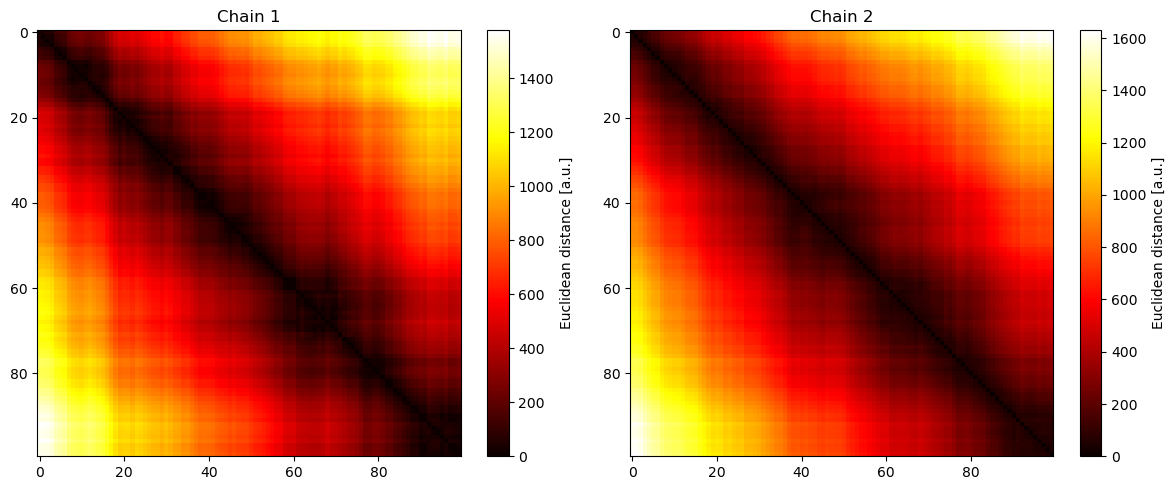

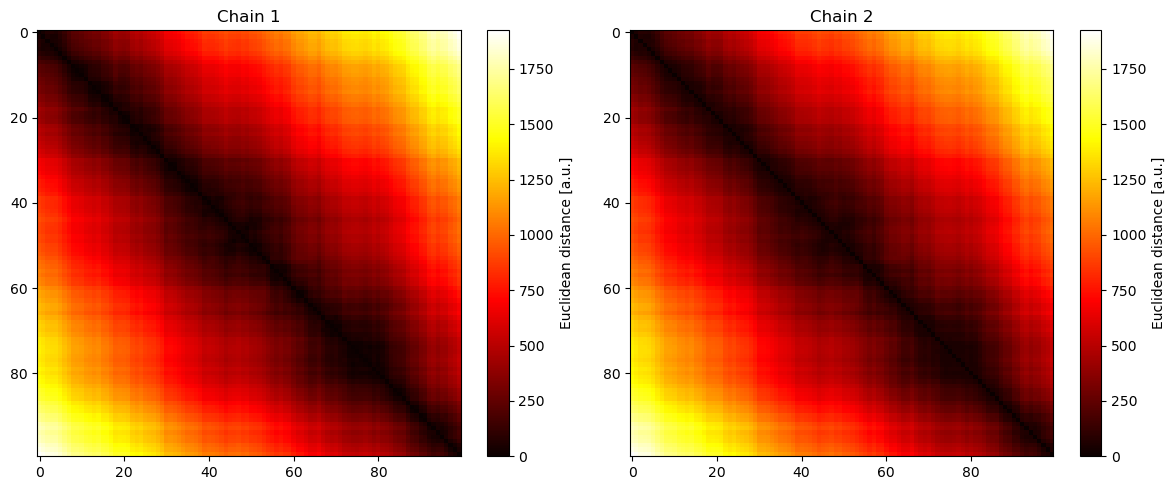

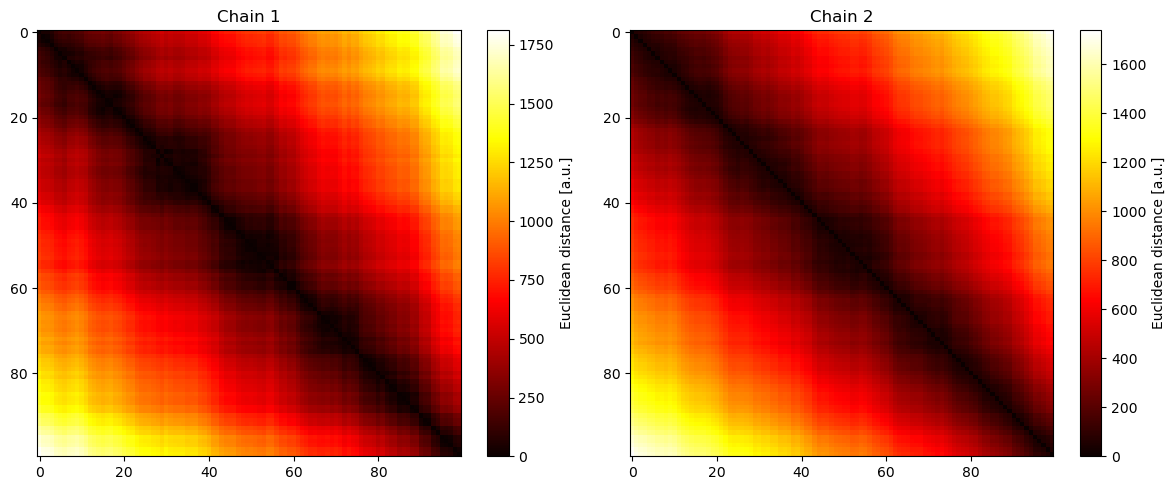

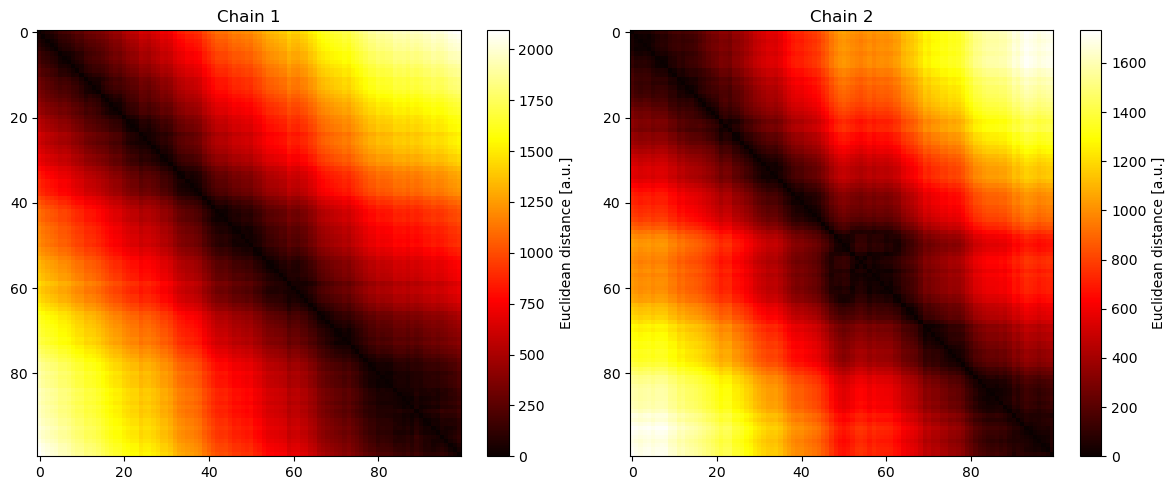

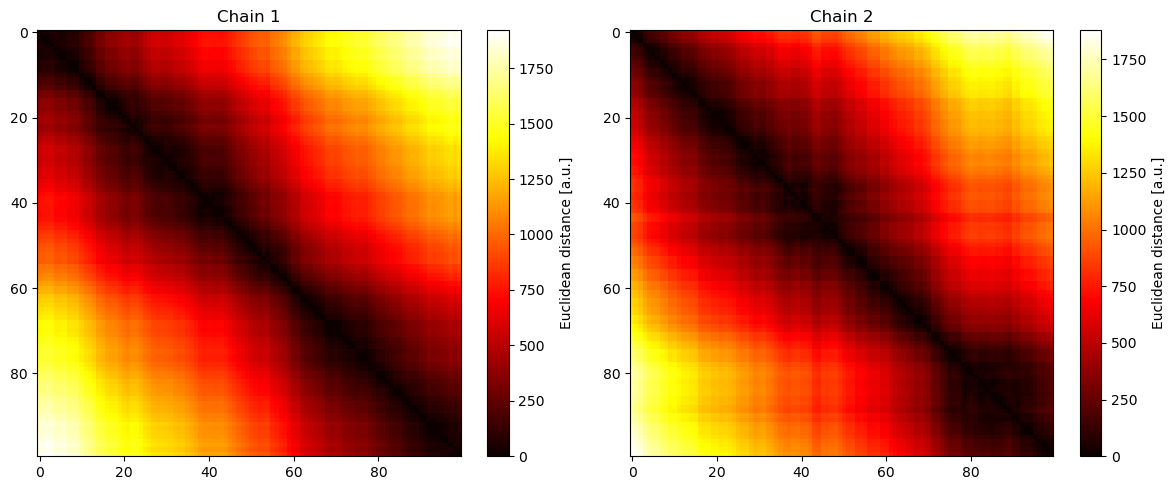

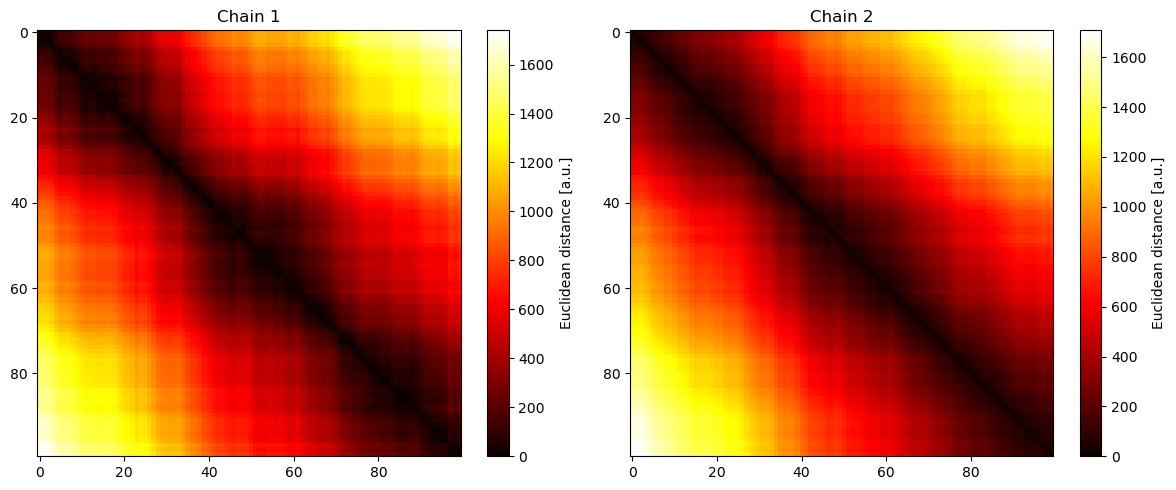

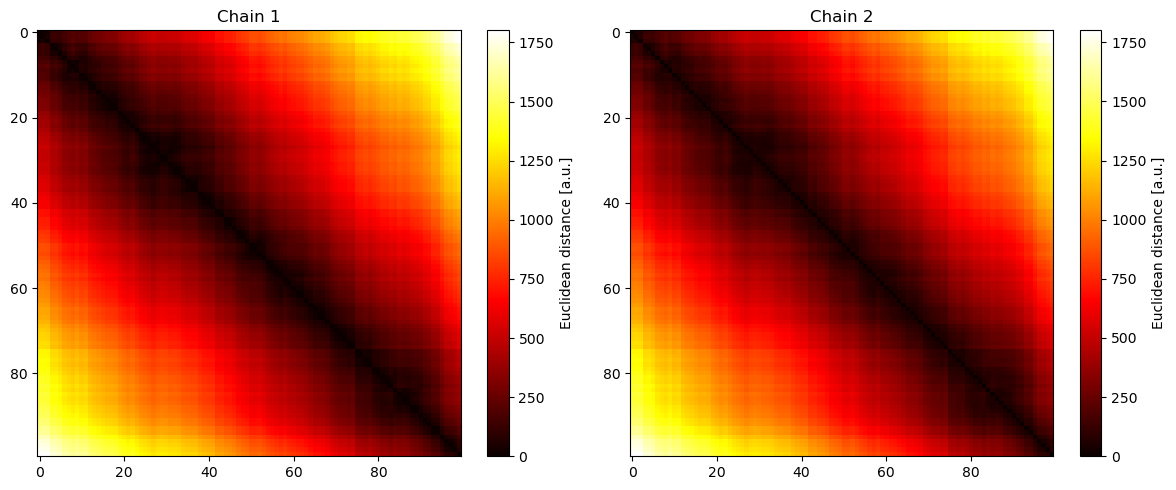

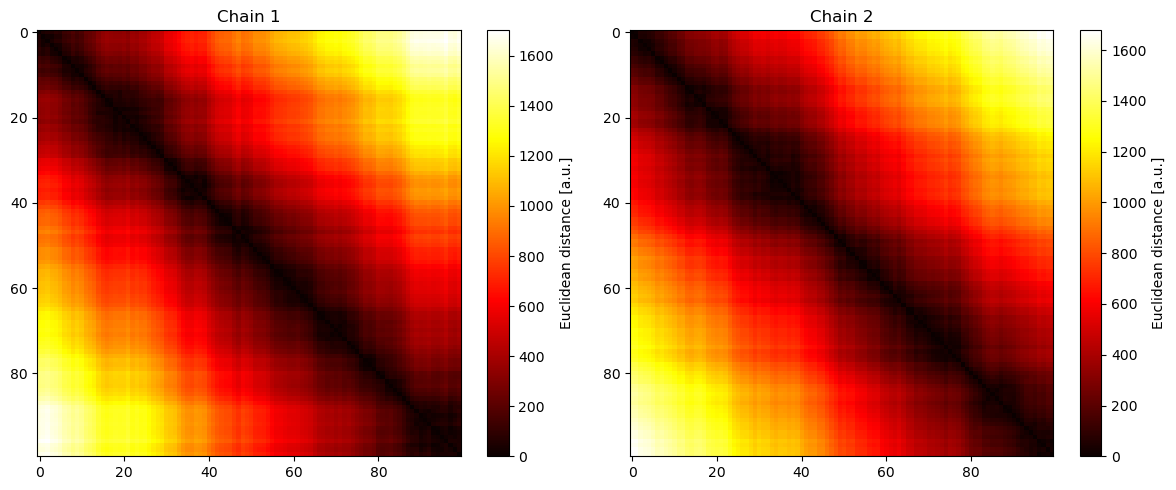

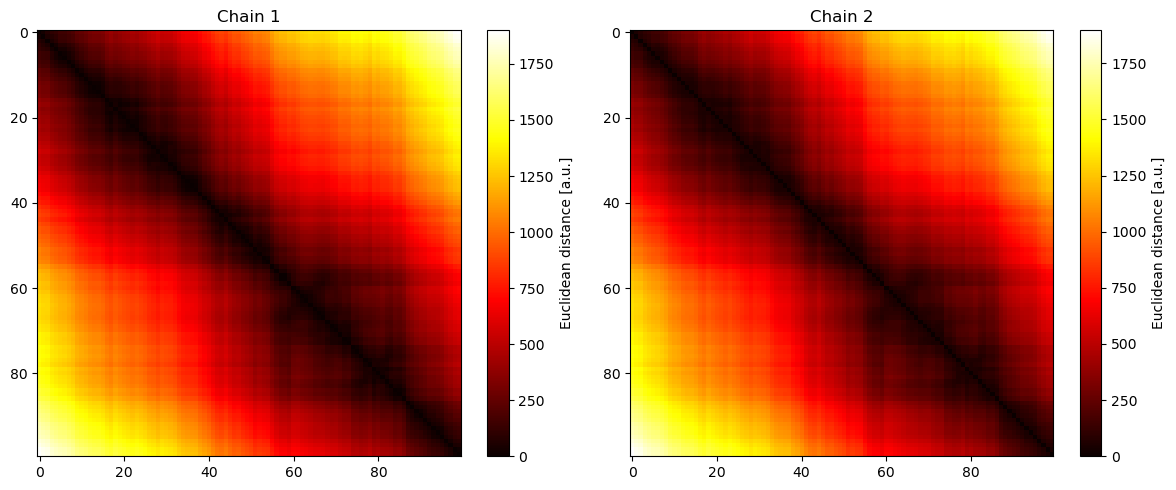

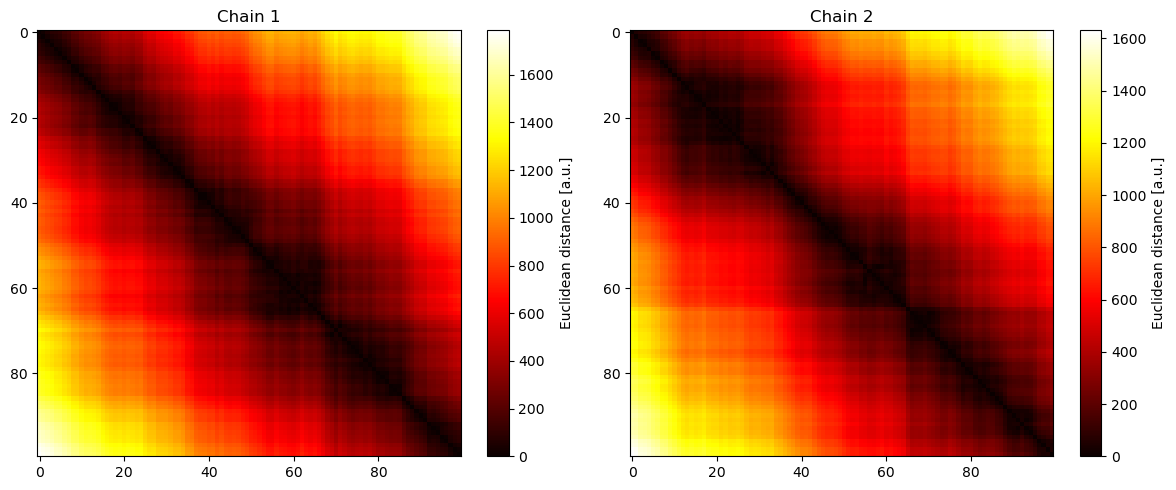

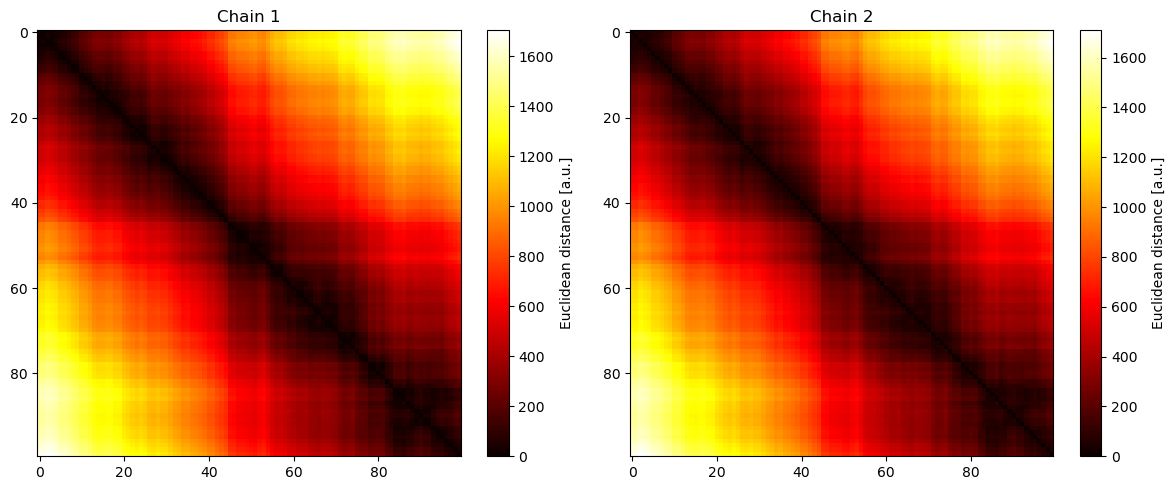

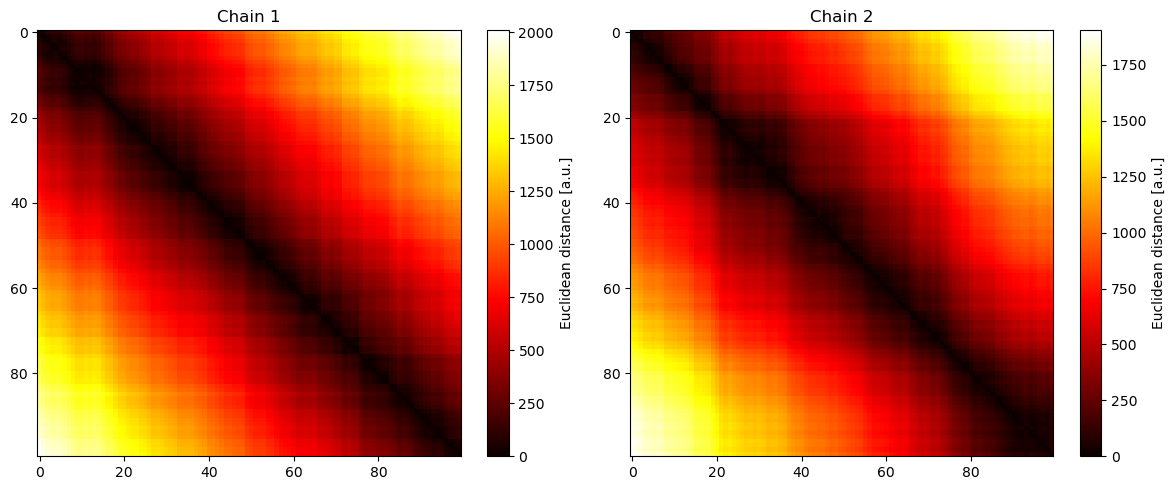

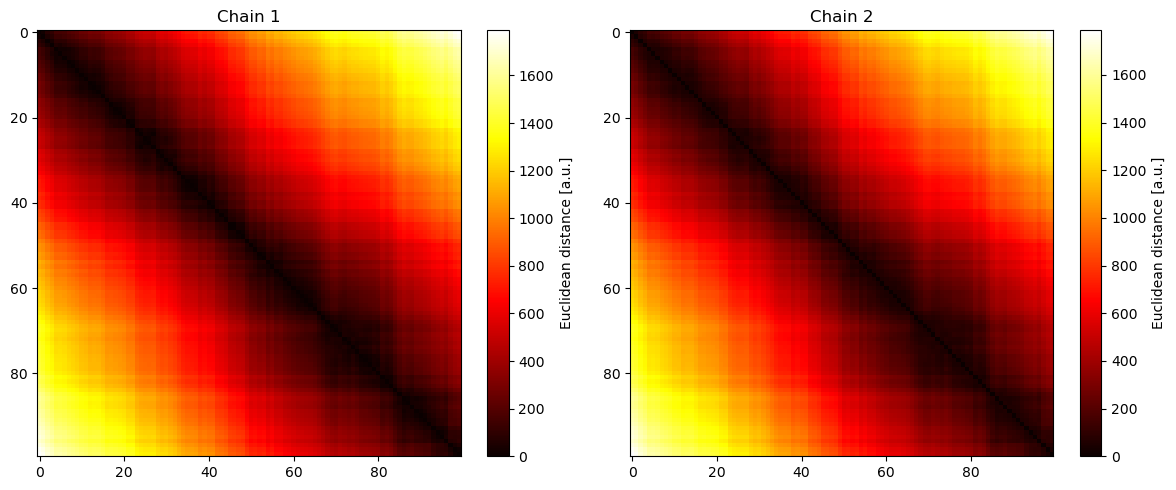

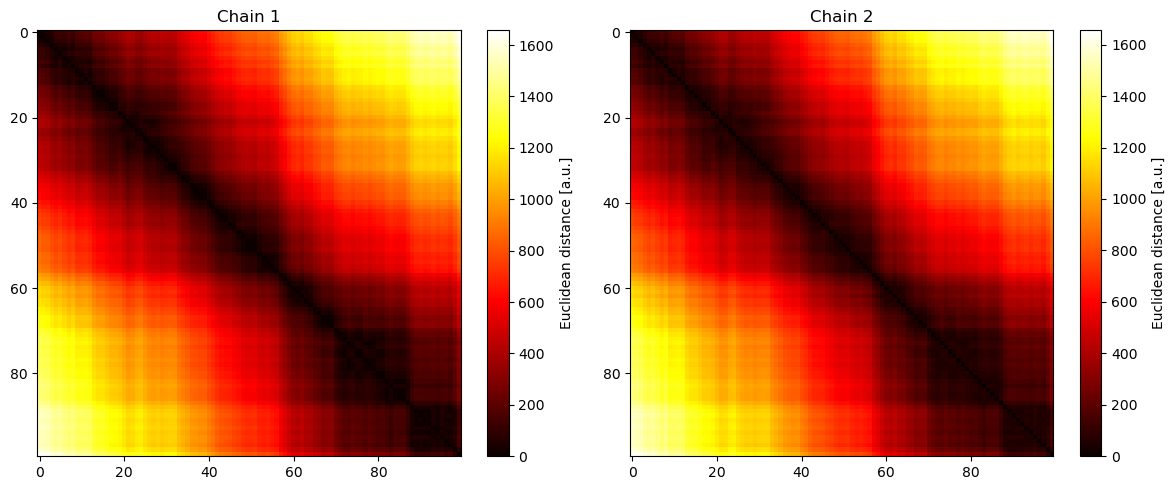

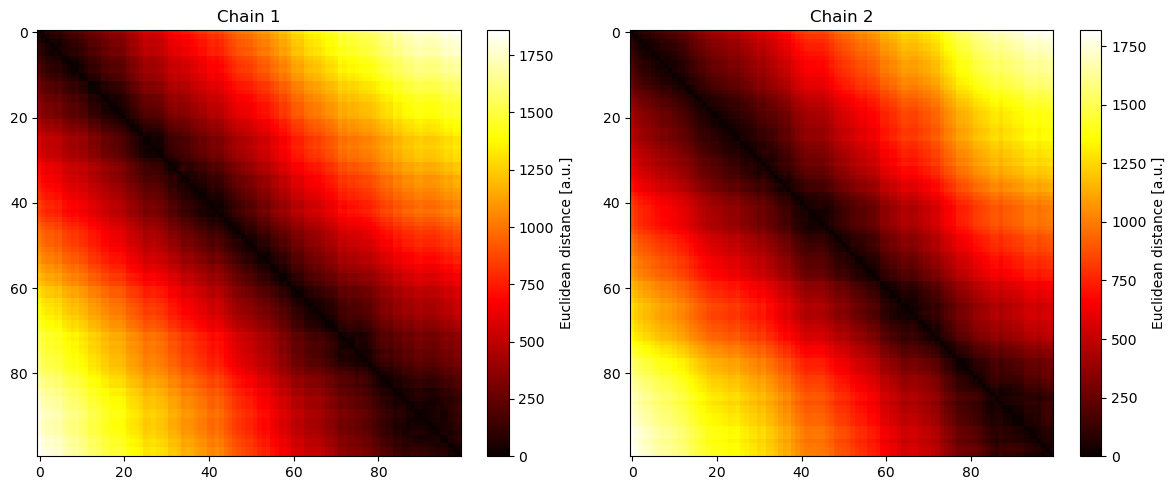

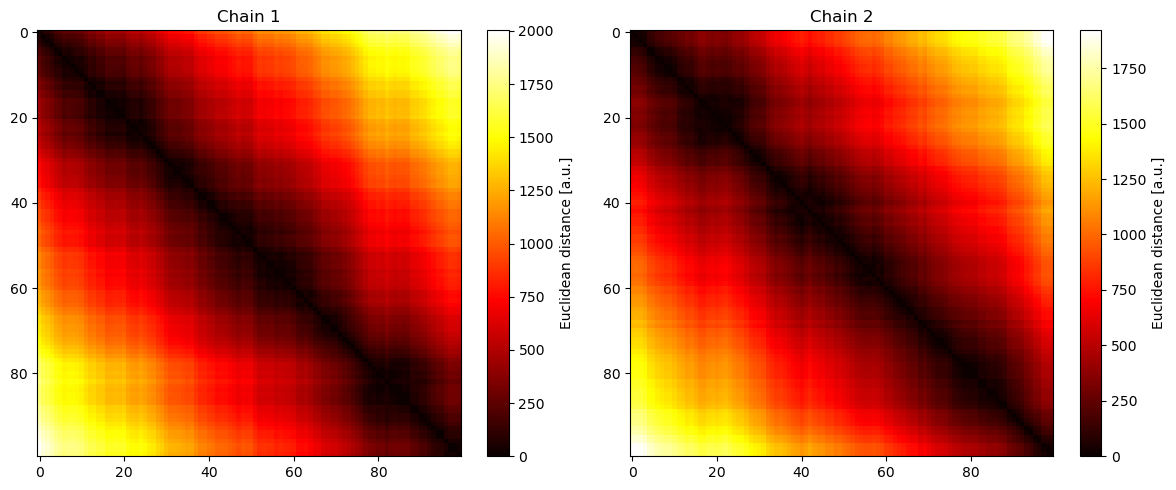

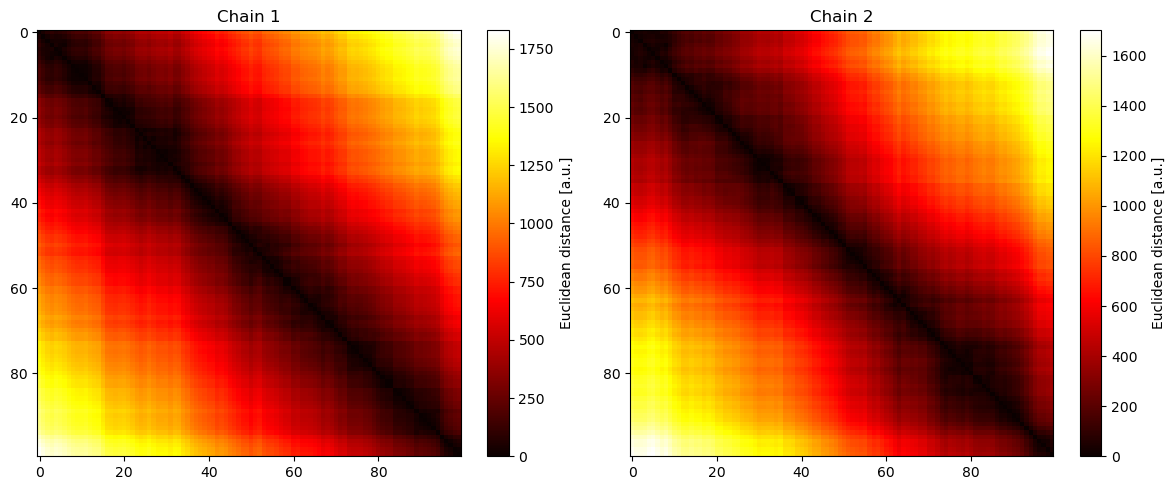

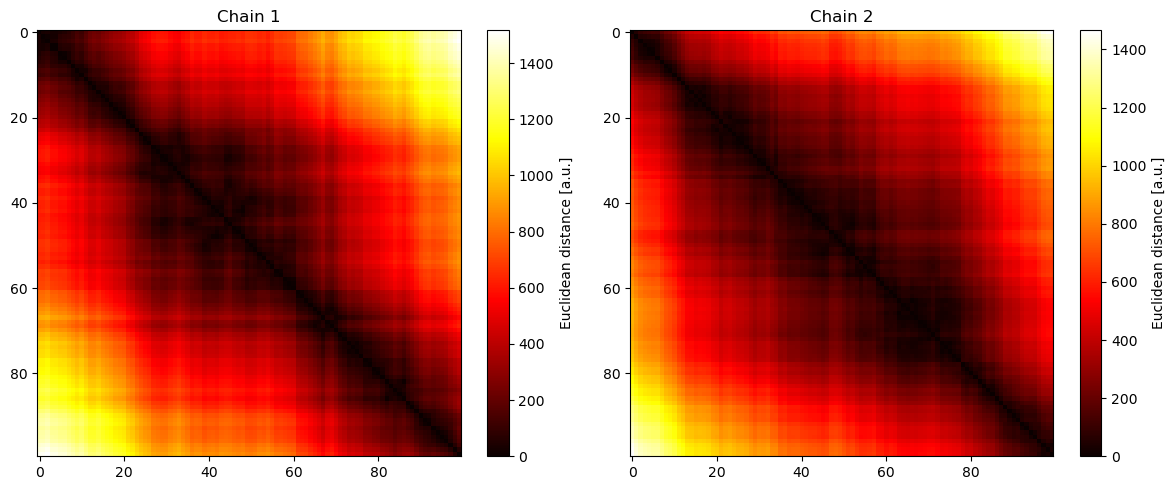

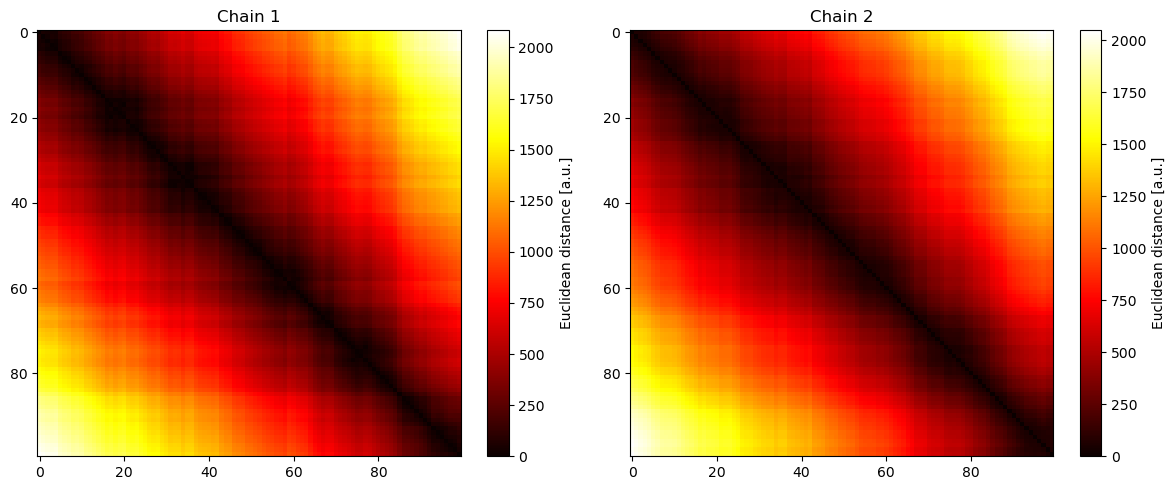

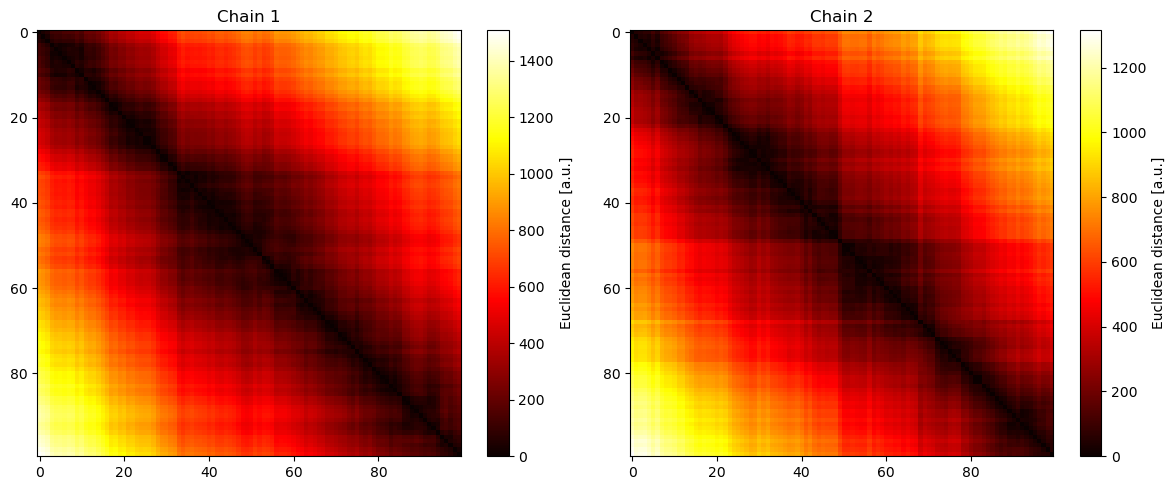

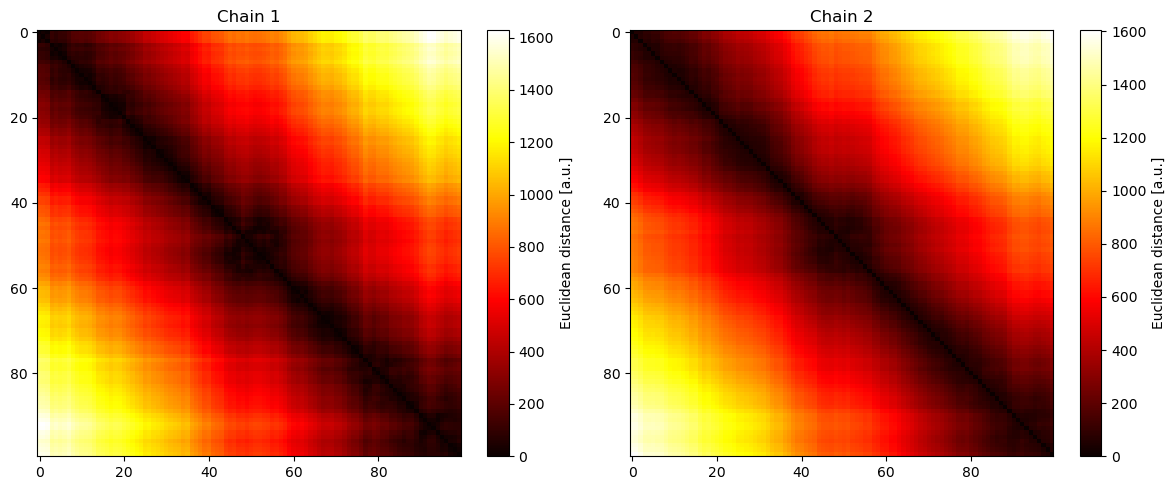

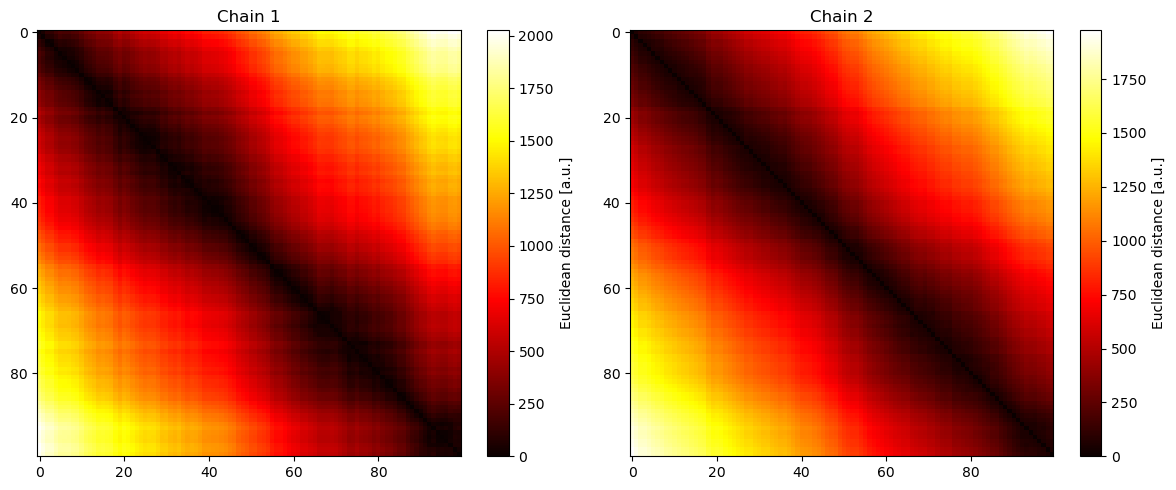

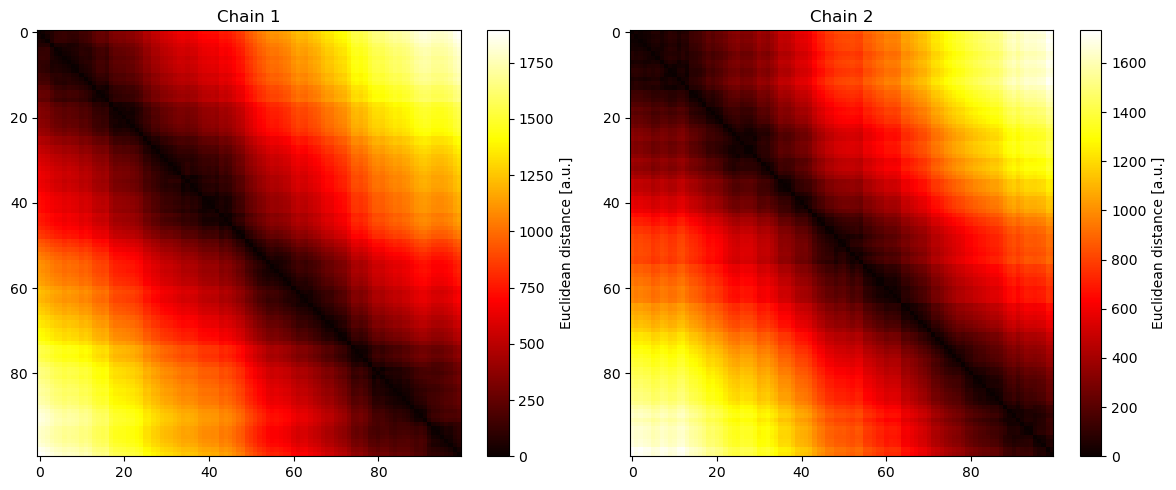

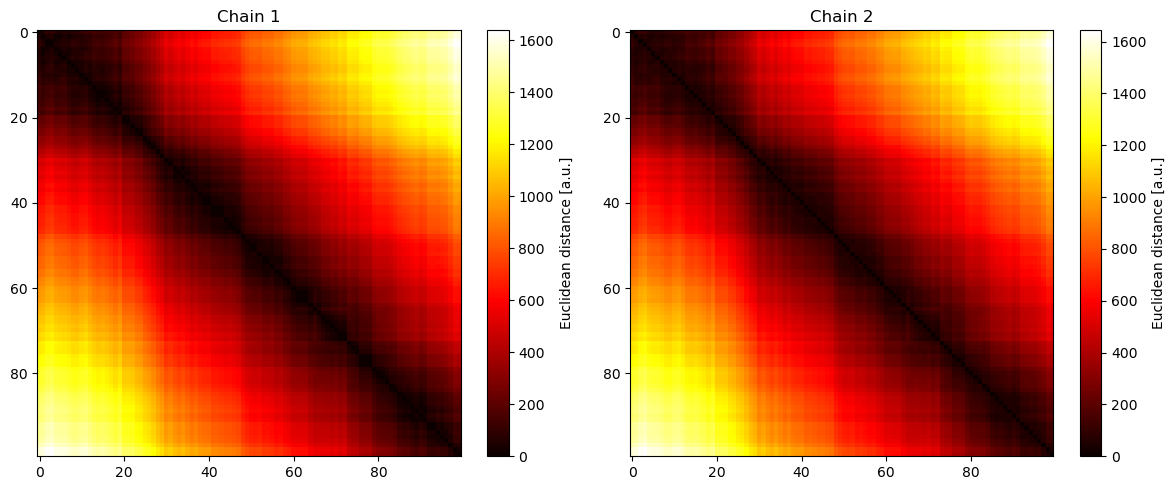

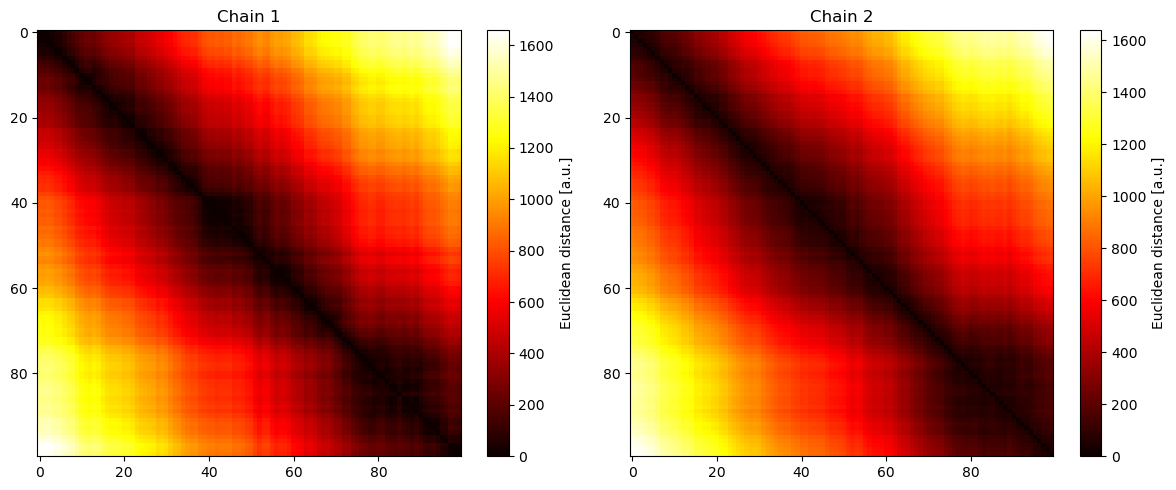

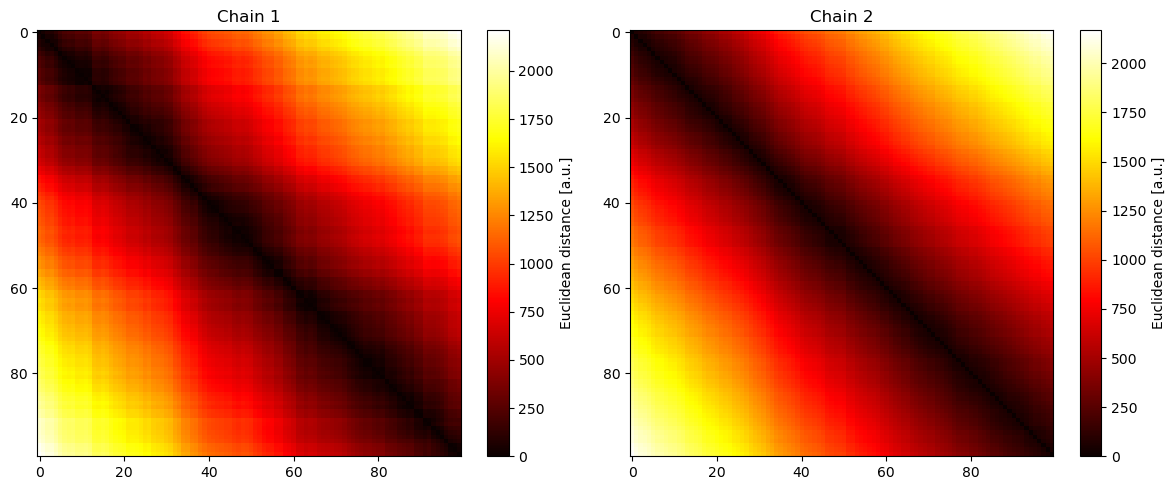

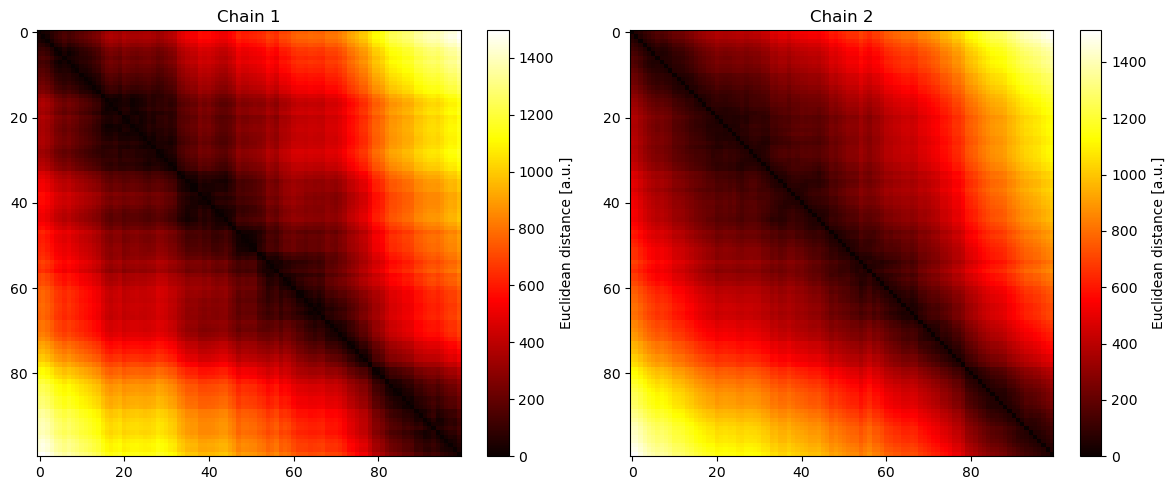

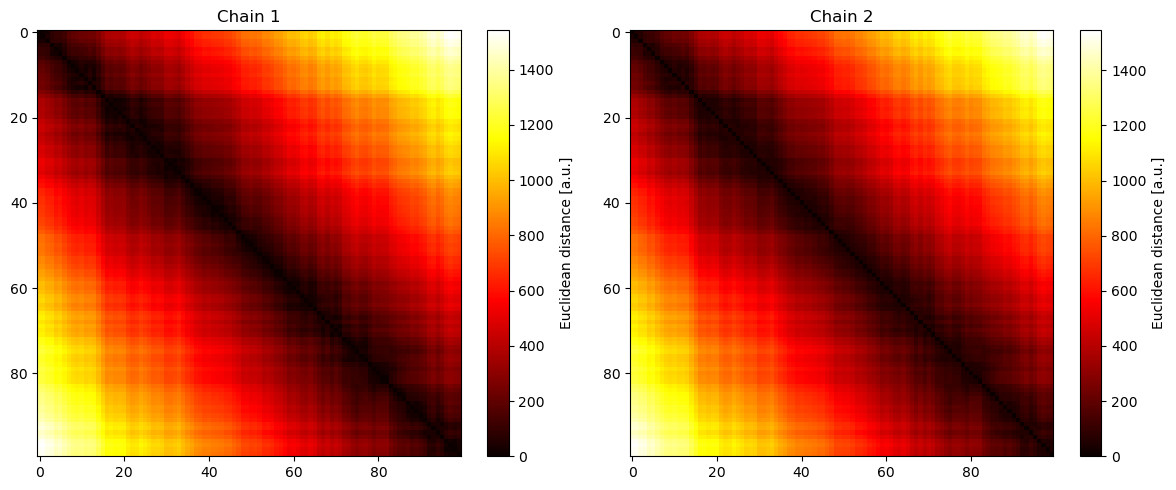

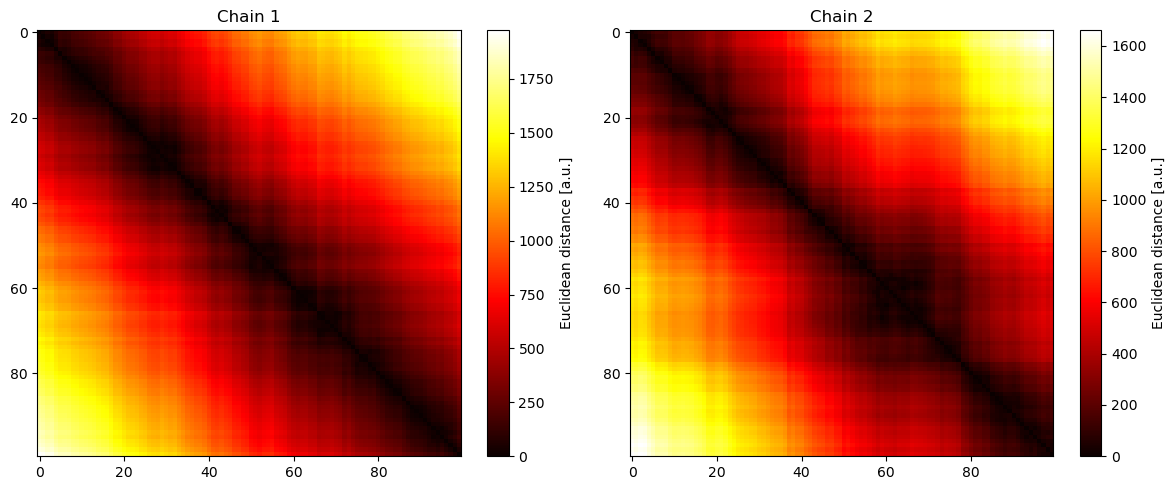

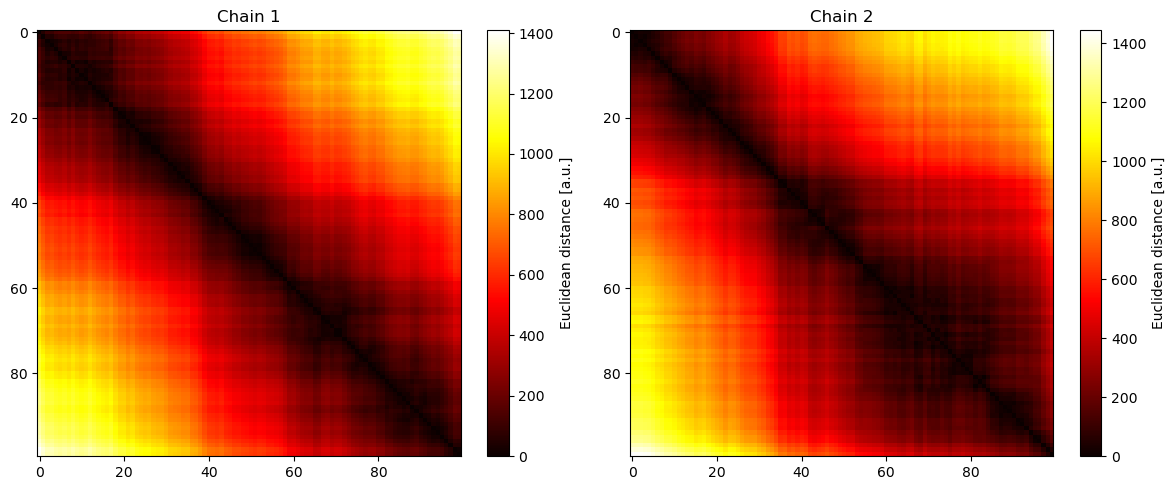

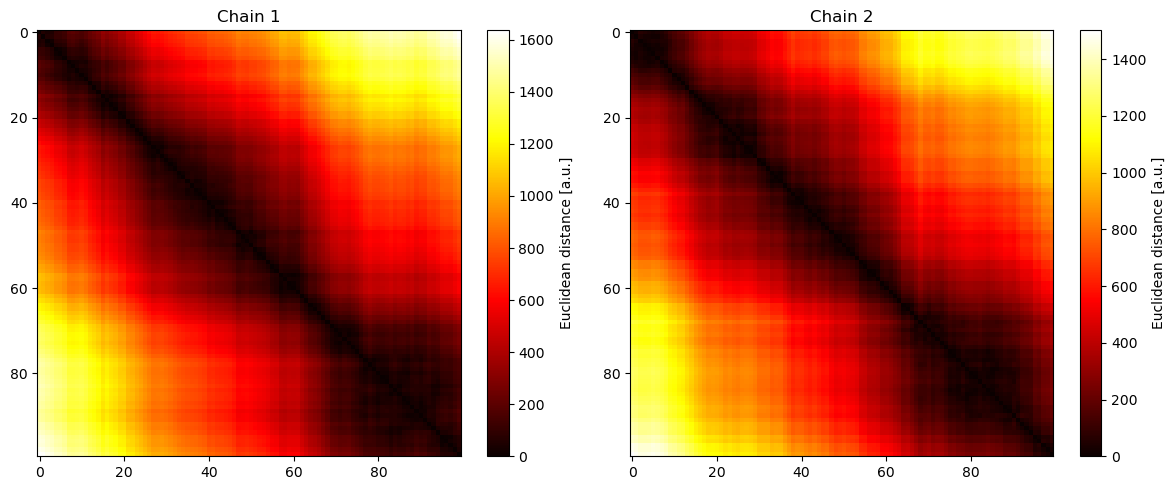

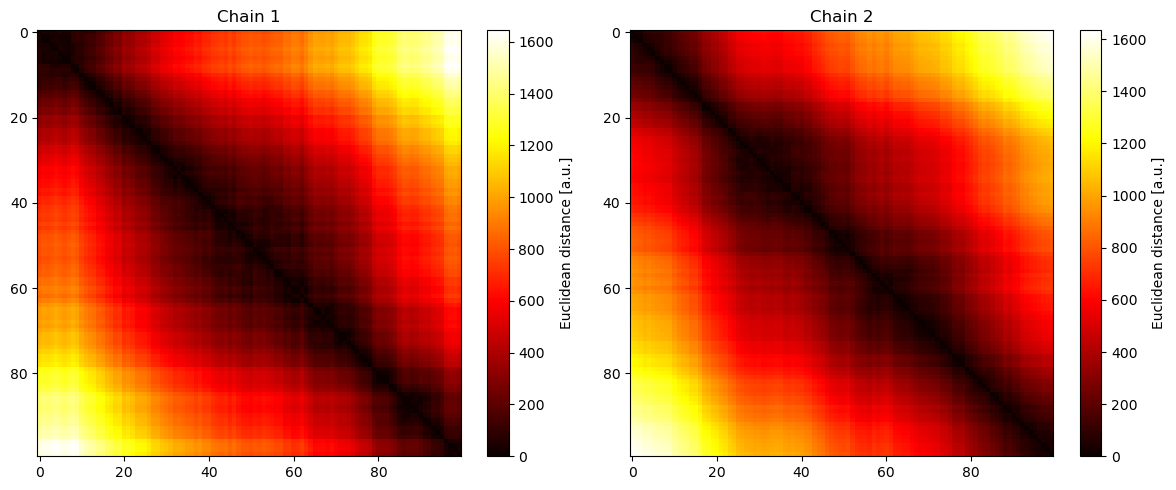

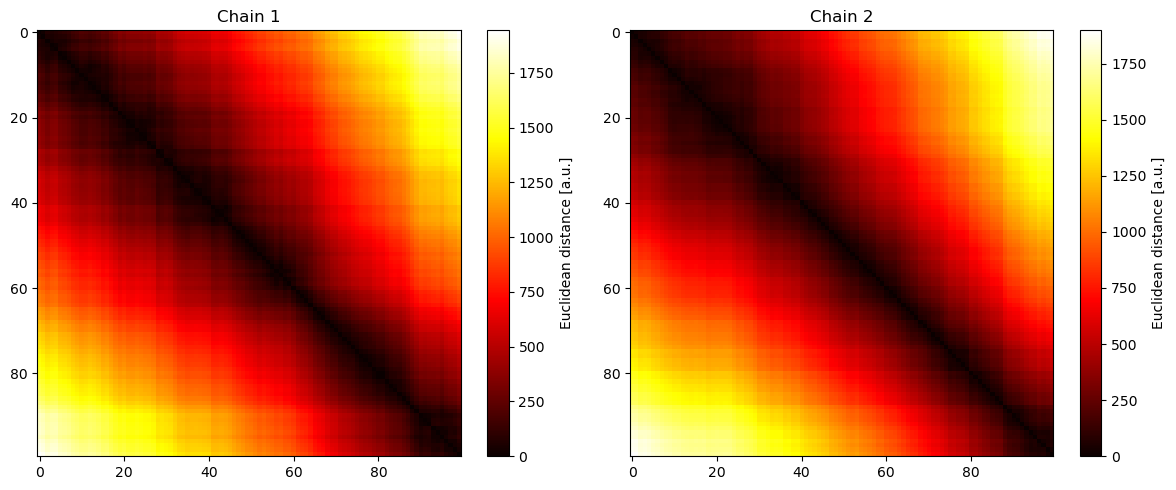

In [36]:
for i in range(100):
    compare_distance_maps(true_means[true_idx][i], pred_means[pred_idx][i], type1='flatten_distance_map', type2='flatten_distance_map')

In [34]:
pred_error = np.mean((true_means[true_idx] - pred_means[pred_idx])**2, axis=1)

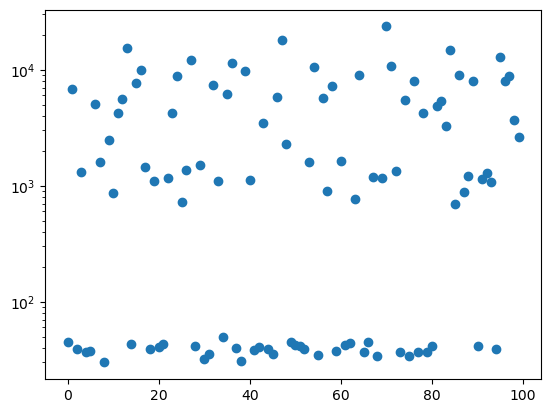

In [37]:
plt.semilogy(pred_error, 'o')